<a href="https://colab.research.google.com/github/pranshutiwari/U_NET_Variant_Novel/blob/main/U_NET_variant_9_2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [439]:
!pip install --upgrade tensorflow-io

In [440]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Polygon
from PIL import Image
from tensorflow.data import AUTOTUNE

!pip install tensorflow_io
import tensorflow_io as tfio
import time
import numpy as np

In [441]:
import numpy as np

def create_binary_image(segmented_image, threshold_value):
    combined_image = np.zeros((224, 224))

    for i in range(224):
        for j in range(224):
            # Combine the RGB channels using a specific formula
            combined_image[i, j] = 0.3 * segmented_image[i, j, 0] + 0.6 * segmented_image[i, j, 1] + 0.1 * segmented_image[i, j, 2]

    # Create the binary image based on the threshold value
    binary_image = np.where(combined_image > threshold_value, 1, 0).astype('uint8')

    return binary_image

In [442]:
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.image import resize as tf_image_resize
from tensorflow.image import convert_image_dtype as tf_image_convert_image_dtype
from tensorflow.io import read_file as tf_io_read_file
from tensorflow.io import decode_png as tf_io_decode_png
from tensorflow.data import AUTOTUNE

In [443]:
from google.colab import drive

# Check if the directory is empty or doesn't exist
import os
if not os.path.exists('/content/drive') or not os.listdir('/content/drive'):
  drive.mount('/content/drive')
else:
  print("The '/content/drive' directory is not empty. Please clear it before mounting Google Drive.")

The '/content/drive' directory is not empty. Please clear it before mounting Google Drive.


In [444]:
def load_img_masks(input_img_path, target_img_path, img_size):
    input_img = tf_io_read_file(input_img_path)
    input_img = tf_io_decode_png(input_img,channels=3)
    input_img = tf_image_resize(input_img, img_size)
    input_img = tf_image_convert_image_dtype(input_img, tf.float32)
    input_img = tf.cast(input_img, tf.float32) / 255.0
    target_img = tf_io_read_file(target_img_path)
    target_img = tf_io_decode_png(target_img, channels=1)
    target_img = tf_image_resize(target_img, img_size, method="nearest")
    target_img = tf.cast(target_img, tf.float32) / 255.0
    target_img= tf.where(target_img > 0.5, 1, 0)
    target_img = tf.clip_by_value(target_img, 0, 1)
    # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    return input_img, target_img



# Code to convert image to right format and then create a data set!

In [445]:
def load_img_train(input_img_path, img_size):
    input_img = tf_io_read_file(input_img_path)# Read file a
    input_img = tf_io_decode_png(input_img,channels=3)# convert into tensor
    input_img = tf_image_resize(input_img, img_size)# reisize
    input_img = tf_image_convert_image_dtype(input_img, tf.float32)#convert into float
    input_img = tf.cast(input_img, tf.float32) / 255.0
    return input_img

In [446]:
def load_img_target(target_img_path, img_size):
    target_img = tf_io_read_file(target_img_path)
    target_img = tf_io_decode_png(target_img, channels=1)
    target_img = tf_image_resize(target_img, img_size, method="nearest")
    target_img = tf.cast(target_img, tf.float32) / 255.0
    target_img= tf.where(target_img > 0.5, 1, 0)
    target_img = tf.clip_by_value(target_img, 0, 1)
    return target_img

In [447]:
def get_dataset(batch_size, img_size, input_img_paths, target_img_paths, max_dataset_len=None):
    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    input_img_paths= tf_data.Dataset.list_files(input_img_paths, shuffle=False)
    target_img_paths = tf_data.Dataset.list_files(target_img_paths, shuffle=False)
    dataset = tf_data.Dataset.zip((input_img_paths,target_img_paths))
    dataset = dataset.map(
        lambda x, y: load_img_masks(x, y,img_size),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return dataset.batch(batch_size)

# Create a Data set for Auto Encoder based Tf dataset so that we can pass the file paths into auto encoder. But this dataset creation for auto encoder also resize each image in file path of dataset

In [448]:
def get_dataset_encoder_only(batch_size, img_size, input_img_paths, max_dataset_len=None):
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
    input_img_paths = tf_data.Dataset.list_files(input_img_paths, shuffle=False)
    X_train = input_img_paths.map(
        lambda x: load_img_train(x, img_size),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return X_train.batch(batch_size)

# We are not batching it as dataset will be batched. No need to double batch and hence

In [449]:
def get_dataset_target_only( img_size, target_img_paths, max_dataset_len=None):
    if max_dataset_len:
        target_img_paths = target_img_paths[:max_dataset_len]
    target_img_paths = tf_data.Dataset.list_files(target_img_paths, shuffle=False)
    y_train = target_img_paths.map(
        lambda x: load_img_target(x, img_size),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return y_train

In [450]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [451]:
def extraction(dataset1,datset2):
  y_true=np.empty()
  y_pred=np.empty()
  for item in dataset1:
     y.append(item)
  for item in dataset2:
    y.append(item)
  return y_true,y_pred

In [452]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="yE5qq3qJAV85LLM0M7Nj")
project = rf.workspace("se-qznqk").project("image_segment_insulator_repeat")
version = project.version(3)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Image_Segment_Insulator_Repeat-3 in coco-segmentation:: 100%|██████████| 107/107 [00:00<00:00, 3644.79it/s]


In [453]:
dataset.location

'/content/Image_Segment_Insulator_Repeat-3'

1. Create A Director if directory does notexist 2. If it does ezist we need to remove all files using shutil

In [454]:
directory = '/content/drive/My Drive/Image_Segmentation_Insulator7'
import shutil
import os

# create file_list if previous directory exist from re-run
if not os.path.exists(directory):
    os.makedirs(directory)
else:
    file_list = [f for f in os.listdir(directory)]



while len(file_list) > 0:
    shutil.rmtree(os.path.join(directory, file_list[0]))
    file_list = os.listdir(directory)  # Update file_list
    file_list = [f for f in os.listdir(directory)]

file_list

[]

1  Move files from Roboflow downloaded content folder to Main Drive folder

In [455]:
!mv "/content/Image_Segment_Insulator_Repeat-3" "/content/drive/My Drive/Image_Segmentation_Insulator7"

In [456]:
path='/content/drive/My Drive/Image_Segmentation_Insulator7'
import os
sub_folder=[]
folder=os.listdir(path)
print(folder)
# When images are moved form Roboflow director -all images are stored in a sub-folder which needs to be restructured

['Image_Segment_Insulator_Repeat-3']


In [457]:
path='/content/drive/My Drive/Image_Segmentation_Insulator7'
import os
sub_folder=[]
folder=os.listdir(path)
print(folder)

import os

old_directory_name = '/content/drive/My Drive/Image_Segmentation_Insulator7/Image_Segment_Insulator_Repeat-3'# The downladed folder itslef has a sub folder which needs to be structured
new_directory_name ='/content/drive/My Drive/Image_Segmentation_Insulator7/Image'
# Check if the new directory name already exists
if not os.path.exists(new_directory_name):
    # Rename the directory
    os.rename(old_directory_name, new_directory_name)
    print("Directory renamed successfully")
else:
    print("New directory name already exists. Rename operation skipped")



for item in os.listdir(new_directory_name ):
  if  not item.endswith ('.txt'):
     sub_folder.append(item)#Append, Test, Train, Valid Data in the subfolder
print(sub_folder)
if len(sub_folder)==4:
  sub_folder.remove('Mask')# to remove previous data

json_annot=[]
for each  in sub_folder:
        new_items =os.listdir(new_directory_name+'/'+each)# name of images or annotation file in each subfolder of new directory name
        print(new_items)# Each sub folder has .json fil and all theimage#
        new_path=os.path.join(new_directory_name+'/'+each +'/'+new_items[0])
        json_annot.append(new_path)# All annotations file aregoing into json_annot folder
        print(new_path)
        image_path=os.path.join(new_directory_name+'/'+each+'/'+new_items[1])#example of image 1


['Image_Segment_Insulator_Repeat-3']
Directory renamed successfully
['test', 'train', 'valid']
['_annotations.coco.json', 'iplrd01-063_png.rf.885360c3e5ac53c5aea1baed57dabff3.jpg', 'ipnrd01-030_png.rf.6f05ef11dfe9c248daa3087d05b92a16.jpg', 'ipnrd01-074_png.rf.deae30961add1b7a27e2c0f2397c6dda.jpg', 'ipnrd01-107_png.rf.645d83c3200758586fa16609f7368d0a.jpg', 'ipvrd01-031_png.rf.cb4494fcf3ffb4a351216b86c99ceadb.jpg', 'ipvrd01-086_png.rf.12a456717c66cbca4da4a55185ce6d3f.jpg', 'ipvrd01-119_png.rf.3f616fc197930c52da2bb8980304f5a3.jpg', 'isbrd01-007_png.rf.ac560703f6ef8f170811f06a08bf6547.jpg', 'isbrd01-035_png.rf.3a8701b9950f1a1f3f78e3ef149b800f.jpg', 'isbrd01-058_png.rf.279dba481241cc0b0f061c9b5a94d9eb.jpg', 'isbrd01-109_png.rf.75df195a16e887b581e9fe494860a590.jpg']
/content/drive/My Drive/Image_Segmentation_Insulator7/Image/test/_annotations.coco.json
['_annotations.coco.json', 'iplrd01-001_png.rf.f07ded8636bb93c48b823271f607ec45.jpg', 'iplrd01-002_png.rf.74ed3e6498b88335879f296983225640.jp

In [458]:
sub_folder
sub_folder_path=[]
for item in sub_folder:
  new_item=os.listdir(new_directory_name+'/'+item)
  new_path=os.path.join(new_directory_name+'/'+item)
  sub_folder_path.append(new_path)



# Function to find JSON files in the specified directory
def find_json_files(directory):
    json_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            json_files.append(os.path.join(directory, filename))
    return json_files

json_annot=[find_json_files(item) for item in sub_folder_path]

In [459]:
json_annot
import itertools

flat_list = list(itertools.chain.from_iterable(json_annot))

json_annot=flat_list


In [460]:
for each  in sub_folder:
        new_items =os.listdir(new_directory_name+'/'+each)# name of images or annotation file in each subfolder of new directory name
        print(new_items)# Each sub folder has .json fil and all theimage#
        new_path=os.path.join(new_directory_name+'/'+each +'/'+new_items[0])
        print(new_path)
        image_path=os.path.join(new_directory_name+'/'+each+'/'+new_items[1])#example of image 1

['_annotations.coco.json', 'iplrd01-063_png.rf.885360c3e5ac53c5aea1baed57dabff3.jpg', 'ipnrd01-030_png.rf.6f05ef11dfe9c248daa3087d05b92a16.jpg', 'ipnrd01-074_png.rf.deae30961add1b7a27e2c0f2397c6dda.jpg', 'ipnrd01-107_png.rf.645d83c3200758586fa16609f7368d0a.jpg', 'ipvrd01-031_png.rf.cb4494fcf3ffb4a351216b86c99ceadb.jpg', 'ipvrd01-086_png.rf.12a456717c66cbca4da4a55185ce6d3f.jpg', 'ipvrd01-119_png.rf.3f616fc197930c52da2bb8980304f5a3.jpg', 'isbrd01-007_png.rf.ac560703f6ef8f170811f06a08bf6547.jpg', 'isbrd01-035_png.rf.3a8701b9950f1a1f3f78e3ef149b800f.jpg', 'isbrd01-058_png.rf.279dba481241cc0b0f061c9b5a94d9eb.jpg', 'isbrd01-109_png.rf.75df195a16e887b581e9fe494860a590.jpg']
/content/drive/My Drive/Image_Segmentation_Insulator7/Image/test/_annotations.coco.json
['_annotations.coco.json', 'iplrd01-001_png.rf.f07ded8636bb93c48b823271f607ec45.jpg', 'iplrd01-002_png.rf.74ed3e6498b88335879f296983225640.jpg', 'iplrd01-007_png.rf.b4885ae314331aadda342b320d5780b5.jpg', 'iplrd01-009_png.rf.1ded4eaee6a5

In [461]:
p=Image.open(image_path)
image_width, image_height = p.size
print(image_width,image_height)

640 640


In [462]:
json_annot

['/content/drive/My Drive/Image_Segmentation_Insulator7/Image/test/_annotations.coco.json',
 '/content/drive/My Drive/Image_Segmentation_Insulator7/Image/train/_annotations.coco.json',
 '/content/drive/My Drive/Image_Segmentation_Insulator7/Image/valid/_annotations.coco.json']

In [463]:
import cv2
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import json
from PIL import Image, ImageDraw

with open(json_annot[0], 'r', encoding='latin-1') as file:
    json_object = json.loads(file.read())
    print(json_object.keys())
    print(json_object['annotations'])
    print(json_object['images'])



dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [63, 0, 461.25, 598.125], 'area': 275885.156, 'segmentation': [[361.875, 0, 261.875, 80, 226.875, 28.75, 196.875, 26.25, 145.625, 45, 96.25, 88.125, 132.5, 121.875, 146.25, 151.875, 143.75, 193.125, 107.5, 265.625, 143.125, 281.25, 152.5, 305.625, 140.625, 321.25, 84.375, 335, 75, 353.125, 101.875, 373.75, 148.125, 383.75, 156.25, 404.375, 148.125, 422.5, 100.625, 432.5, 75, 450.625, 62.5, 561.875, 95.625, 587.5, 262.5, 598.125, 425.625, 585, 501.875, 567.5, 523.75, 548.125, 506.25, 436.875, 489.375, 421.25, 441.875, 415, 425, 401.875, 426.875, 375, 488.125, 358.75, 498.75, 336.875, 483.125, 317.5, 422.5, 308.125, 425, 275.625, 480.625, 255, 487.5, 231.875, 435.625, 201.25, 416.25, 174.375, 417.5, 131.875, 455, 78.125, 444.375, 57.5, 381.25, 26.875, 410.625, 0, 361.875, 0]], 'iscrowd': 0}, {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [243, 453, 48.75, 186.875

In [464]:
json_object['annotations'][0]
# Each annotation file has id, image id , area annoted, bbox details and segmentation values

{'id': 0,
 'image_id': 0,
 'category_id': 1,
 'bbox': [63, 0, 461.25, 598.125],
 'area': 275885.156,
 'segmentation': [[361.875,
   0,
   261.875,
   80,
   226.875,
   28.75,
   196.875,
   26.25,
   145.625,
   45,
   96.25,
   88.125,
   132.5,
   121.875,
   146.25,
   151.875,
   143.75,
   193.125,
   107.5,
   265.625,
   143.125,
   281.25,
   152.5,
   305.625,
   140.625,
   321.25,
   84.375,
   335,
   75,
   353.125,
   101.875,
   373.75,
   148.125,
   383.75,
   156.25,
   404.375,
   148.125,
   422.5,
   100.625,
   432.5,
   75,
   450.625,
   62.5,
   561.875,
   95.625,
   587.5,
   262.5,
   598.125,
   425.625,
   585,
   501.875,
   567.5,
   523.75,
   548.125,
   506.25,
   436.875,
   489.375,
   421.25,
   441.875,
   415,
   425,
   401.875,
   426.875,
   375,
   488.125,
   358.75,
   498.75,
   336.875,
   483.125,
   317.5,
   422.5,
   308.125,
   425,
   275.625,
   480.625,
   255,
   487.5,
   231.875,
   435.625,
   201.25,
   416.25,
   174.375,
 

In [465]:
image_name=[]
image_file_name={}
for id in json_object['annotations']:
   k=id['image_id']
   r=json_object['images'][k]['file_name']
   print(r)



ipnrd01-030_png.rf.6f05ef11dfe9c248daa3087d05b92a16.jpg
isbrd01-058_png.rf.279dba481241cc0b0f061c9b5a94d9eb.jpg
isbrd01-058_png.rf.279dba481241cc0b0f061c9b5a94d9eb.jpg
ipnrd01-074_png.rf.deae30961add1b7a27e2c0f2397c6dda.jpg
ipvrd01-119_png.rf.3f616fc197930c52da2bb8980304f5a3.jpg
iplrd01-063_png.rf.885360c3e5ac53c5aea1baed57dabff3.jpg
iplrd01-063_png.rf.885360c3e5ac53c5aea1baed57dabff3.jpg
isbrd01-035_png.rf.3a8701b9950f1a1f3f78e3ef149b800f.jpg
ipvrd01-086_png.rf.12a456717c66cbca4da4a55185ce6d3f.jpg
ipnrd01-107_png.rf.645d83c3200758586fa16609f7368d0a.jpg
ipvrd01-031_png.rf.cb4494fcf3ffb4a351216b86c99ceadb.jpg
isbrd01-109_png.rf.75df195a16e887b581e9fe494860a590.jpg
isbrd01-007_png.rf.ac560703f6ef8f170811f06a08bf6547.jpg


Each annotation file has image id and image unique number we need to extract the image file name from image id

In [466]:
def file_name(id_number):
  for item in json_object['images']:
    if item['id']==id_number:
      return item['file_name']
# Extracts the file name associated to image id

In [467]:
json_annot
# Each folder has annotation file

['/content/drive/My Drive/Image_Segmentation_Insulator7/Image/test/_annotations.coco.json',
 '/content/drive/My Drive/Image_Segmentation_Insulator7/Image/train/_annotations.coco.json',
 '/content/drive/My Drive/Image_Segmentation_Insulator7/Image/valid/_annotations.coco.json']

In [468]:
for i in range(len(json_annot)):# for each item in Json _annotation
  os.makedirs(path+'/Mask/' + sub_folder[i], exist_ok=True)
  print(sub_folder[i])
  print(path+'/Mask/' + sub_folder[i])
  with open(json_annot[i], 'r') as file:
        json_object = json.loads(file.read())
        for item in (json_object['annotations']):
            image_id = item['image_id']
            file_name_image=file_name(image_id)# image name extraction
            category_id = item['category_id']# Category Id extraction
            polygons = item['segmentation']#  extracts poygons
            for polygon_points in polygons:
                  polygon = Polygon([(polygon_points[i], polygon_points[i+1]) for i in range(0, len(polygon_points), 2)])
        # Generate mask based on the polygon
                  mask = np.zeros((image_height, image_width), dtype=np.uint8)  # Initialize mask with zeros
                  cv2.fillPoly(mask, [np.array(polygon.exterior.coords, dtype=np.int32)], color=1)  # Fill the polygon with value 1 in the mask
            mask_path = os.path.join(path+'/Mask/'+ sub_folder[i], f'{file_name_image}_mask.png')
            cv2.imwrite(mask_path, mask*255)  # Save the mask

# The above code does the following:
# We have annotation directory but we need to create a new folder and put all annotaion segmented areas to mask it and save it in a Mask folder

test
/content/drive/My Drive/Image_Segmentation_Insulator7/Mask/test
train
/content/drive/My Drive/Image_Segmentation_Insulator7/Mask/train
valid
/content/drive/My Drive/Image_Segmentation_Insulator7/Mask/valid


In [469]:
input_dir= '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image'
output_dir = '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask'



In [470]:
sub_folder

['test', 'train', 'valid']

In [471]:
output_img_paths=[[] for  i  in range(len(sub_folder))]
output_img_paths


[[], [], []]

In [472]:
output_dir
for item in os.listdir(output_dir+'/'+ sub_folder[i]):
  print(item)

iplrd01-030_png.rf.003d8c953f858e0093762bda97565e85.jpg_mask.png
iplrd01-051_png.rf.585c694ae9db82547aafd3da461efc97.jpg_mask.png
ipvrd01-104_png.rf.0bd0a66989081dab0e05dc4038d7b7cf.jpg_mask.png
ipnrd01-096_png.rf.2c82143bb688bc3e6261c1b35df28d4f.jpg_mask.png
isbrd01-061_png.rf.6236d7a1cfb491bcb3db8165d6c7d7d7.jpg_mask.png
isbrd01-033_png.rf.9d5058873fcfdd850cd5f17abdfb3464.jpg_mask.png
ipnrd01-041_png.rf.4d6647afef81173ea511fef87a6f855e.jpg_mask.png
isbrd01-115_png.rf.e1c54330ebe634366d6c934327d9f4b4.jpg_mask.png
ipvrd01-072_png.rf.93b53287ca8a924733f29f5619df9ee3.jpg_mask.png
isbrd01-025_png.rf.b5ae1ceeb3e79257992ff5962cc2771f.jpg_mask.png
iplrd01-117_png.rf.1c2ada2ddab3c8e555c9e05b0d4793f3.jpg_mask.png
isbrd01-078_png.rf.dddca3c37a4f1dc0c8544dc2d63a56ad.jpg_mask.png
ipvrd01-100_png.rf.98b5a8972bd61f21c870e5a14f587dbb.jpg_mask.png
ipvrd01-011_png.rf.7f4901b9ca5152bdad20beb3722e10c4.jpg_mask.png
ipnrd01-101_png.rf.c67bb330efb0f5a17999484314aa2b67.jpg_mask.png
ipnrd01-009_png.rf.e32be4

In [473]:
output_img_paths=[[] for  i  in range(len(sub_folder))]
for i in range(len(sub_folder)):
  for item in os.listdir(output_dir+'/'+ sub_folder[i]):
   if item.endswith('.png') :
     x=os.path.join(output_dir,sub_folder[i],item)# joining path of maks folder+ sub folder +image item in output image path
     output_img_paths[i].append(x)
  print(output_dir+'/'+ sub_folder[i])
sorted(output_img_paths[0])

/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test
/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/train
/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/valid


['/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/iplrd01-063_png.rf.885360c3e5ac53c5aea1baed57dabff3.jpg_mask.png',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/ipnrd01-030_png.rf.6f05ef11dfe9c248daa3087d05b92a16.jpg_mask.png',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/ipnrd01-074_png.rf.deae30961add1b7a27e2c0f2397c6dda.jpg_mask.png',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/ipnrd01-107_png.rf.645d83c3200758586fa16609f7368d0a.jpg_mask.png',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/ipvrd01-031_png.rf.cb4494fcf3ffb4a351216b86c99ceadb.jpg_mask.png',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/ipvrd01-086_png.rf.12a456717c66cbca4da4a55185ce6d3f.jpg_mask.png',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/ipvrd01-119_png.rf.3f616fc197930c52da2bb8980304f5a3.jpg_mask.png',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test/isbrd01-007

In [474]:
mask_path

'/content/drive/My Drive/Image_Segmentation_Insulator7/Mask/valid/ipvrd01-077_png.rf.848cf513931da9bf064be02dcf79f95f.jpg_mask.png'

# We are creating different paths so that annotated images can be directed to right paths

In [475]:
input_img_paths=[[] for  i  in range(len(sub_folder))]#empty list of input paths


for i in range(len(sub_folder)):
 for item in os.listdir(input_dir+'/'+ sub_folder[i]):
   if item.endswith('.jpg') :
     x=os.path.join(input_dir,sub_folder[i],item)
     input_img_paths[i].append(x)

sorted(input_img_paths[0])

['/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/iplrd01-063_png.rf.885360c3e5ac53c5aea1baed57dabff3.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/ipnrd01-030_png.rf.6f05ef11dfe9c248daa3087d05b92a16.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/ipnrd01-074_png.rf.deae30961add1b7a27e2c0f2397c6dda.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/ipnrd01-107_png.rf.645d83c3200758586fa16609f7368d0a.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/ipvrd01-031_png.rf.cb4494fcf3ffb4a351216b86c99ceadb.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/ipvrd01-086_png.rf.12a456717c66cbca4da4a55185ce6d3f.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/ipvrd01-119_png.rf.3f616fc197930c52da2bb8980304f5a3.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/test/isbrd01-007_png.rf.ac560703f6ef8f170811f06a08bf6547.jpg',
 '/conte

In [476]:
input_img_paths[2]

['/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/iplrd01-030_png.rf.003d8c953f858e0093762bda97565e85.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/iplrd01-044_png.rf.b083c12abb40e5d2730185fb5e1e8696.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/iplrd01-051_png.rf.585c694ae9db82547aafd3da461efc97.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/iplrd01-117_png.rf.1c2ada2ddab3c8e555c9e05b0d4793f3.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/ipnrd01-009_png.rf.e32be4768d8d1a19a92c26a4075dffb1.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/ipnrd01-013_png.rf.c703b04ccfbf40d9dd8f0f667d669034.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/ipnrd01-017_png.rf.5abb3e88853ef560a020ef126d12ebf3.jpg',
 '/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/valid/ipnrd01-041_png.rf.4d6647afef81173ea511fef87a6f855e.jpg',


In [477]:
def function_sorting_mask(output_directory,sub_folder):
  output_img_paths=[[] for  i  in range(len(sub_folder))]
  for i in range(len(sub_folder)):
    for item in os.listdir(output_dir+'/'+ sub_folder[i]):
       if item.endswith('.jpg') :
        x=os.path.join(output_dir,sub_folder[i],item)
        input_img_paths[i].append(x)

  return sorted(output_img_paths[0])

In [478]:
def function_sorting(input_directory,sub_folder):

  input_img_paths=[[] for  i  in range(len(sub_folder))]
  for i in range(len(sub_folder)):
    for item in os.listdir(input_dir+'/'+ sub_folder[i]):
       if item.endswith('.jpg') :
        x=os.path.join(input_dir,sub_folder[i],item)
        input_img_paths[i].append(x)

  return sorted(input_img_paths[0])

In [479]:
test_target_paths=sorted(output_img_paths[0])
train_target_paths=sorted(output_img_paths[1])
valid_target_paths=sorted(output_img_paths[2])

test_input_paths= sorted(input_img_paths[0])
train_input_paths=sorted(input_img_paths[1])
valid_input_paths=sorted(input_img_paths[2])

In [480]:
for train_input_path, train_target_path in zip(train_input_paths,train_target_paths):
    print(train_input_path,train_target_path)

for valid_input_path, valid_target_path in zip(valid_input_paths,valid_target_paths):
    print(valid_input_path,valid_target_path)

/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/train/iplrd01-001_png.rf.f07ded8636bb93c48b823271f607ec45.jpg /content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/train/iplrd01-001_png.rf.f07ded8636bb93c48b823271f607ec45.jpg_mask.png
/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/train/iplrd01-002_png.rf.74ed3e6498b88335879f296983225640.jpg /content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/train/iplrd01-002_png.rf.74ed3e6498b88335879f296983225640.jpg_mask.png
/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/train/iplrd01-007_png.rf.b4885ae314331aadda342b320d5780b5.jpg /content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/train/iplrd01-007_png.rf.b4885ae314331aadda342b320d5780b5.jpg_mask.png
/content/drive/MyDrive/Image_Segmentation_Insulator7/Image/train/iplrd01-009_png.rf.1ded4eaee6a51d09ebd49b9c0027380c.jpg /content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/train/iplrd01-009_png.rf.1ded4eaee6a51d09ebd49b9c0027380c.jpg_mask.png


In [481]:
img_size=(160,160)
batch_size=32
train_dataset=get_dataset(batch_size, img_size, input_img_paths=train_input_paths, target_img_paths=train_target_paths, max_dataset_len=None)

In [482]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.int32, name=None))>

In [483]:
valid_dataset=get_dataset(batch_size=32,
            img_size=img_size,
            input_img_paths=valid_input_paths,
            target_img_paths=valid_target_paths,
            max_dataset_len=None)

In [484]:
img_size=(160,160)

# Method 1- Get Model to use 3*3 Filters of 32 number with stride 2 to dwonsample image

In [485]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 2, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model




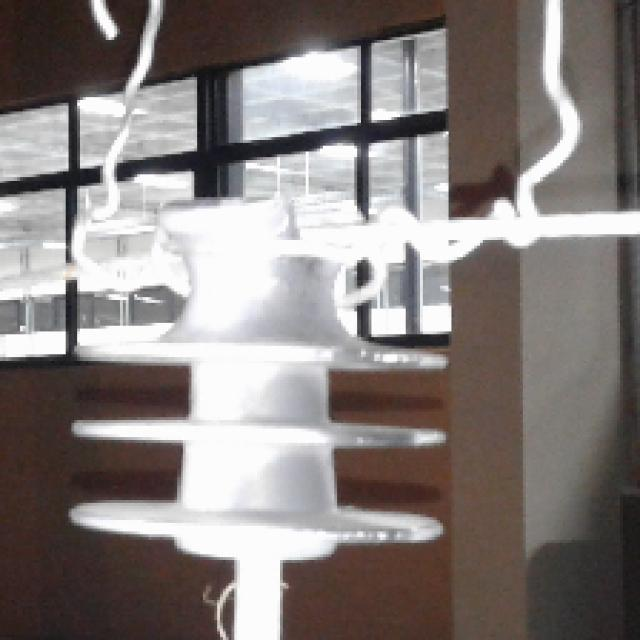

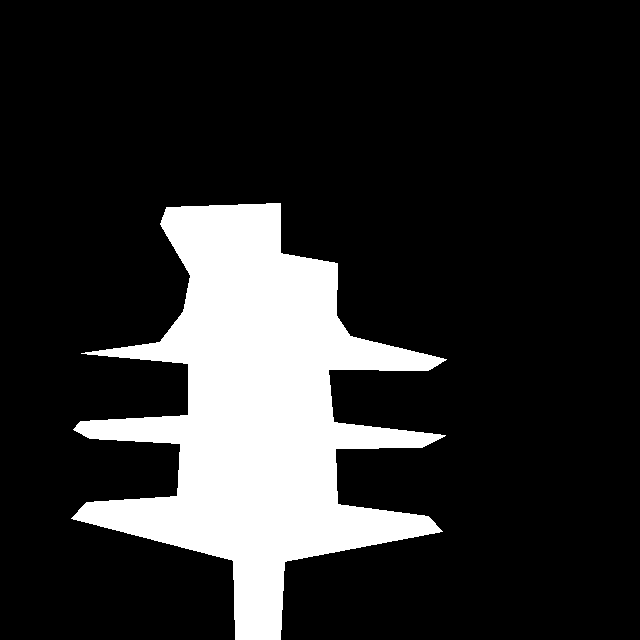

(640, 640)


In [486]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=train_input_paths[8] ))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(train_target_paths[8] ))
display(img)
print(img.size)

In [487]:
import numpy as np
img_array = np.array(img)
print(img_array.shape)

(640, 640, 3)


In [488]:

print(img_size)
num_classes=2
model = get_model(img_size, num_classes)
print(model.summary())

(160, 160)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 80, 80, 32)     │            896 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 80, 80, 32)     │            128 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_90             │ (None, 80, 80, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_91             │ (None, 80, 80, 32)     │              0 │ activation_90[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_36       │ (None, 80, 80, 64)     │          2,400 │ activation_91[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_91    │ (None, 80, 80, 64)     │            256 │ separable_conv2d_36[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_92             │ (None, 80, 80, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_37       │ (None, 80, 80, 64)     │          4,736 │ activation_92[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 80, 80, 64)     │            256 │ separable_conv2d_37[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 40, 40, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 40, 40, 64)     │          2,112 │ activation_90[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_42 (Add)              │ (None, 40, 40, 64)     │              0 │ max_pooling2d_18[0][0… │
│                           │                        │                │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_93             │ (None, 40, 40, 64)     │              0 │ add_42[0][0]           │
│ (Activation)         

 Total params: 2,058,370 (7.85 MB)

 Trainable params: 2,054,594 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

None


In [489]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.int32, name=None))>

In [490]:
len(train_dataset)

3

In [491]:
valid_dataset
train_dataset


<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.int32, name=None))>

In [492]:
import random
random.seed(123)

start_time = time.time()

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 25
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)


Epoch 1/25
3/3 - 31s - 10s/step - accuracy: 0.5998 - loss: 19.6616 - val_accuracy: 0.7787 - val_loss: 144.2592
Epoch 2/25
3/3 - 1s - 168ms/step - accuracy: 0.5258 - loss: 27.2916 - val_accuracy: 0.7796 - val_loss: 12495.8496
Epoch 3/25
3/3 - 0s - 147ms/step - accuracy: 0.3645 - loss: 34.3707 - val_accuracy: 0.7778 - val_loss: 2809.6992
Epoch 4/25
3/3 - 0s - 149ms/step - accuracy: 0.5626 - loss: 5.2645 - val_accuracy: 0.7790 - val_loss: 2443.5334
Epoch 5/25
3/3 - 0s - 141ms/step - accuracy: 0.6838 - loss: 7.6388 - val_accuracy: 0.7790 - val_loss: 913.3279
Epoch 6/25
3/3 - 0s - 148ms/step - accuracy: 0.7050 - loss: 2.1619 - val_accuracy: 0.7790 - val_loss: 678.8123
Epoch 7/25
3/3 - 1s - 171ms/step - accuracy: 0.7130 - loss: 7.2232 - val_accuracy: 0.7790 - val_loss: 516.7807
Epoch 8/25
3/3 - 0s - 153ms/step - accuracy: 0.5128 - loss: 2.0445 - val_accuracy: 0.7790 - val_loss: 334.0271
Epoch 9/25
3/3 - 1s - 257ms/step - accuracy: 0.7178 - loss: 0.9341 - val_accuracy: 0.7729 - val_loss: 141.

In [493]:
from keras.models import load_model
model_archived = load_model('/content/oxford_segmentation.keras')
model_archived.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 80, 80, 32)     │            896 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 80, 80, 32)     │            128 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_90             │ (None, 80, 80, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_91             │ (None, 80, 80, 32)     │              0 │ activation_90[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_36       │ (None, 80, 80, 64)     │          2,400 │ activation_91[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_91    │ (None, 80, 80, 64)     │            256 │ separable_conv2d_36[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_92             │ (None, 80, 80, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_37       │ (None, 80, 80, 64)     │          4,736 │ activation_92[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 80, 80, 64)     │            256 │ separable_conv2d_37[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 40, 40, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 40, 40, 64)     │          2,112 │ activation_90[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_42 (Add)              │ (None, 40, 40, 64)     │              0 │ max_pooling2d_18[0][0… │
│                           │                        │                │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_93             │ (None, 40, 40, 64)     │              0 │ add_42[0][0]           │
│ (Activation)         

 Total params: 6,167,560 (23.53 MB)

 Trainable params: 2,054,594 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

 Optimizer params: 4,109,190 (15.68 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Inference time: 47.83397126197815 seconds


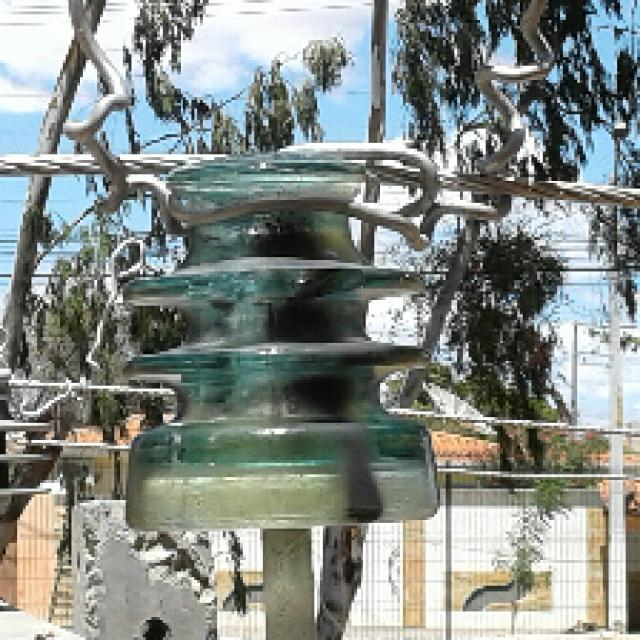

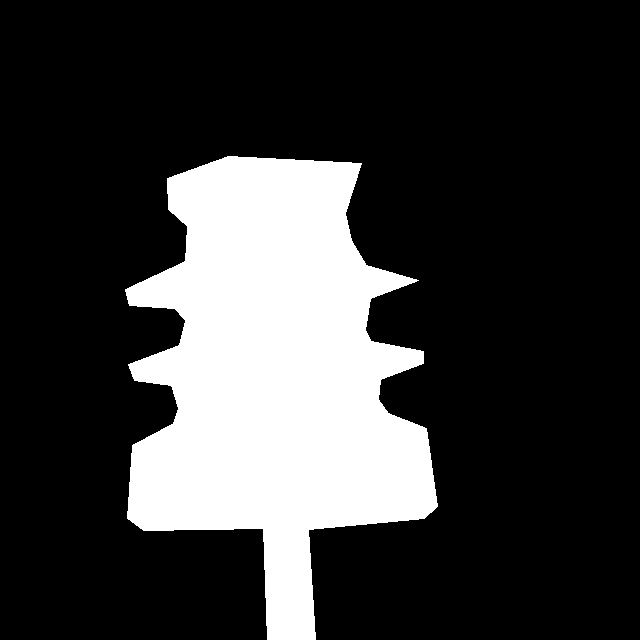

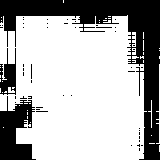

In [494]:
val_preds = model_archived.predict(valid_dataset)
end_time = time.time()

# Calculate the inference time
inference_time = end_time - start_time
print("Inference time: {} seconds".format(inference_time))

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)

# Display results for validation image #10
i = 10
# Display input image
display(Image(filename=valid_input_paths[i]))
# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(valid_target_paths[i]))
display(img)
# Display mask predicted by our model
display_mask(i)

In [495]:
def clear_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):# list the files
            file_path = os.path.join(directory, file)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)  # Remove files
                elif os.path.isdir(file_path):
                    # Remove directories and their contents
                    os.rmdir(file_path)  # Remove empty directories
            except Exception as e:
                print(f"Error deleting file {file_path}: {e}")


In [496]:

import os# Ensure the output directory exists
output_dir_mask = '/content/drive/MyDrive/Image_Segmentation/output_dir/mask'
os.makedirs(output_dir_mask, exist_ok=True)


In [497]:
output_dir_crop='/content/drive/MyDrive/Image_Segmentation/output_dir/crop'
os.makedirs(output_dir_crop, exist_ok=True)
clear_output_directory(output_dir_crop)

In [498]:
def clear_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):# list the files
            file_path = os.path.join(directory, file)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)  # Remove files
                elif os.path.isdir(file_path):
                    # Remove directories and their contents
                    os.rmdir(file_path)  # Remove empty directories
            except Exception as e:
                print(f"Error deleting file {file_path}: {e}")

# Clear the output directory
clear_output_directory(output_dir)

Error deleting file /content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test: [Errno 39] Directory not empty: '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/test'
Error deleting file /content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/train: [Errno 39] Directory not empty: '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/train'
Error deleting file /content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/valid: [Errno 39] Directory not empty: '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask/valid'


In [499]:
len(valid_dataset)
os.path.basename(valid_input_paths[0])
list_names_original=[os.path.basename(valid_input_paths[i]) for i in range(len(valid_input_paths))]
list_names_original
def name_extraction(paths):
  return [os.path.basename(paths[i]) for i in range(len(paths))]

In [500]:
list_names_original=name_extraction(valid_input_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Inference time: 48.03555202484131 seconds


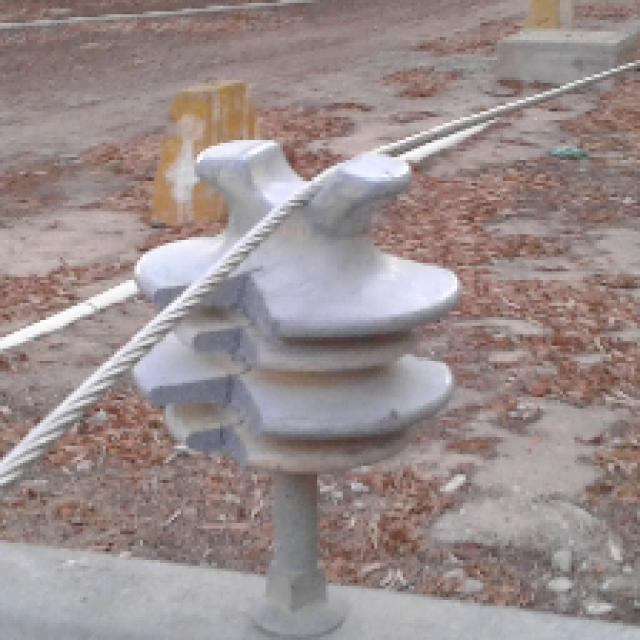

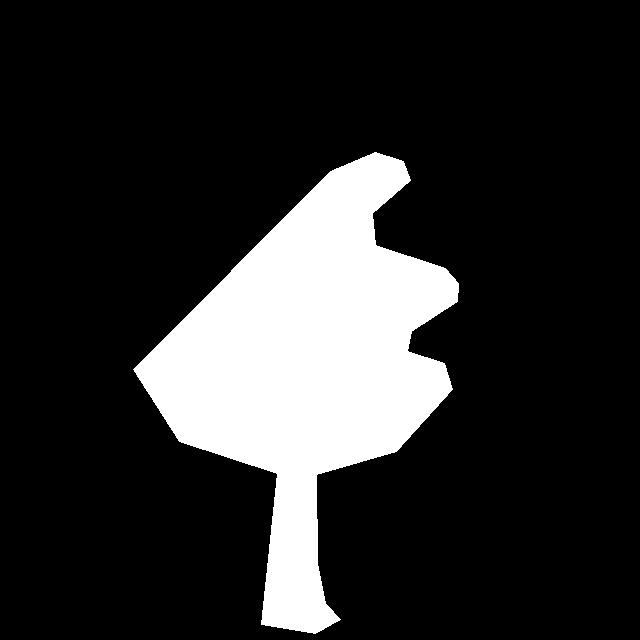

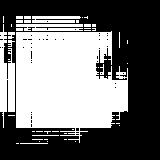

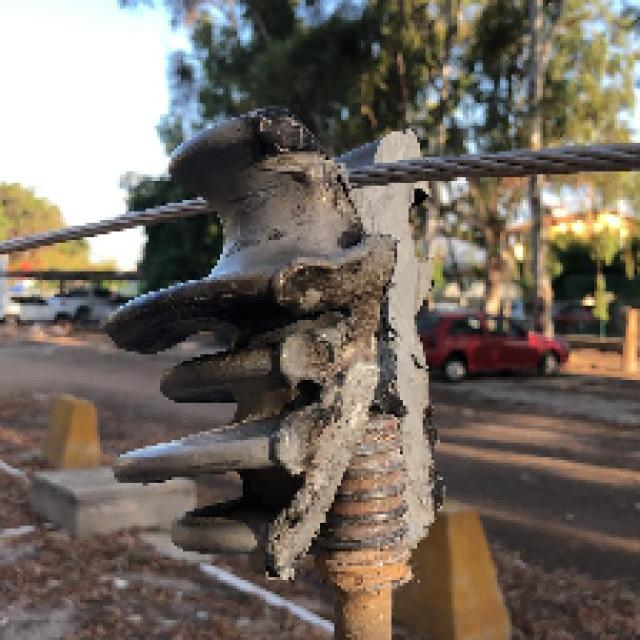

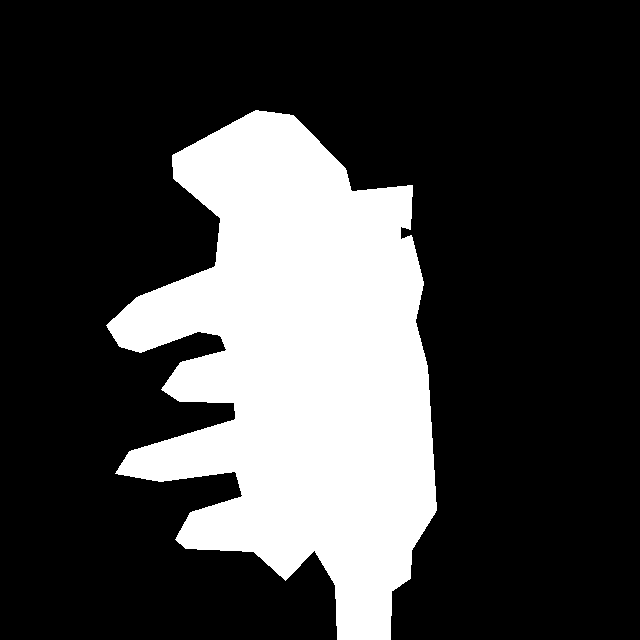

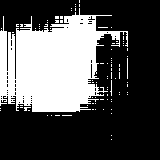

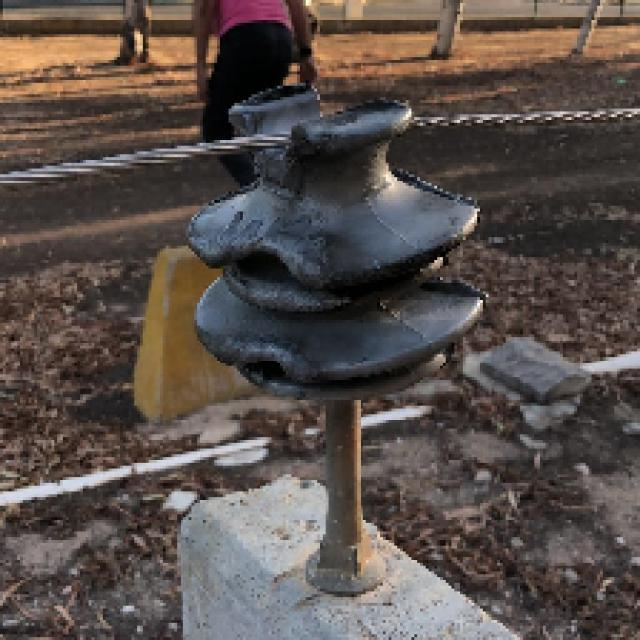

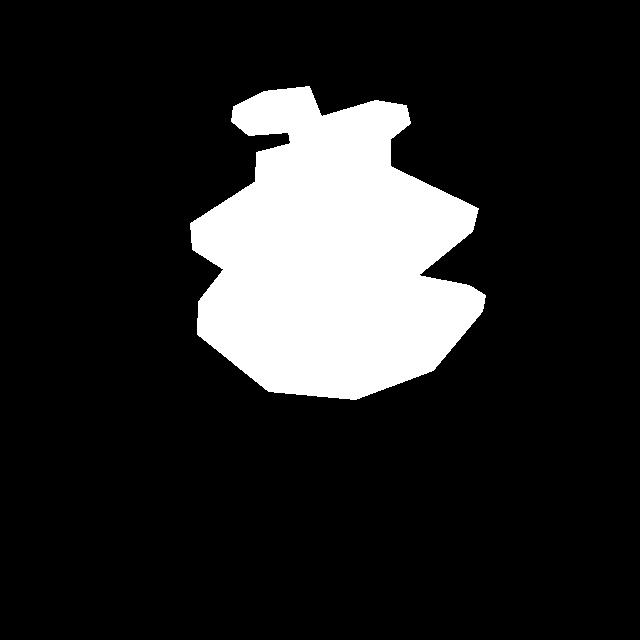

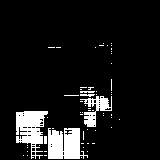

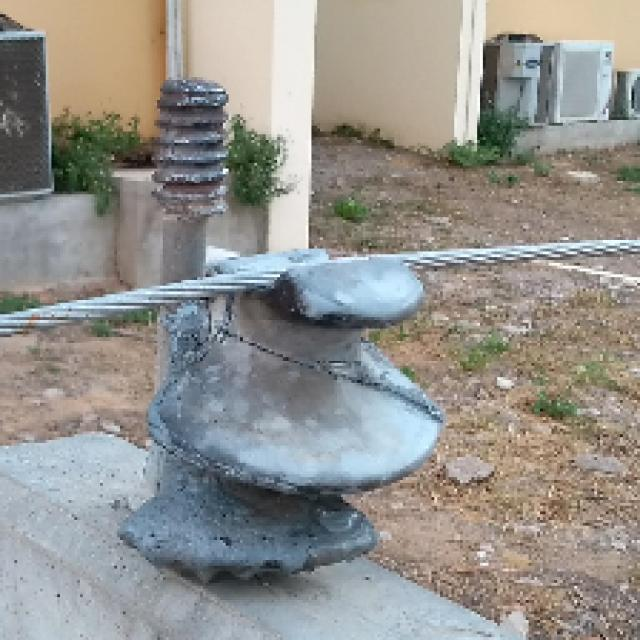

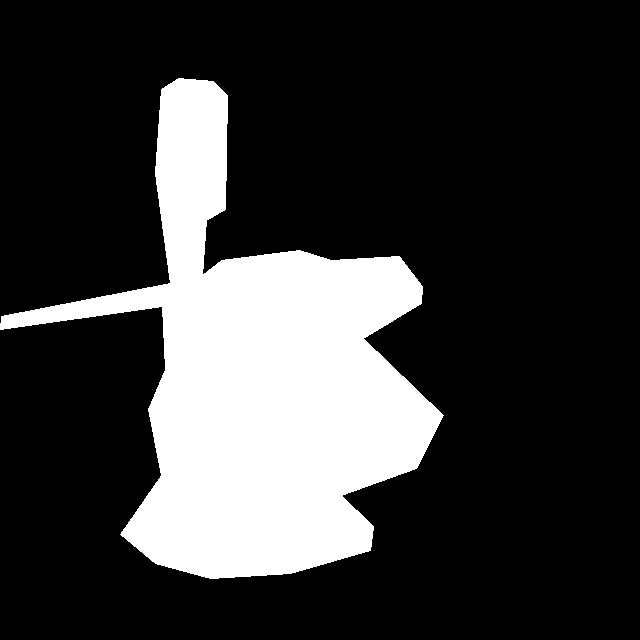

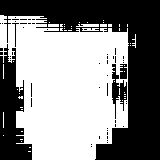

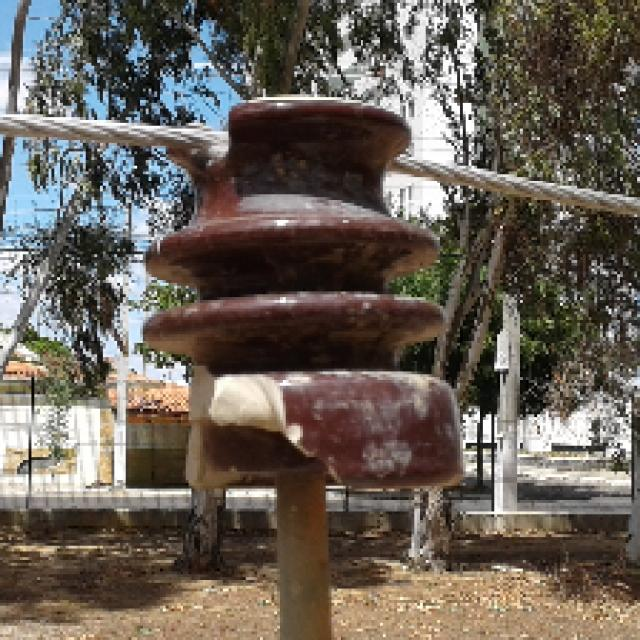

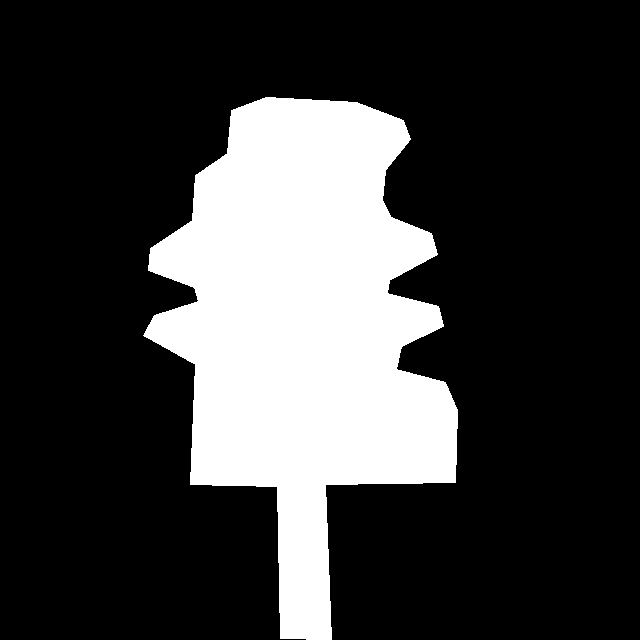

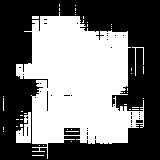

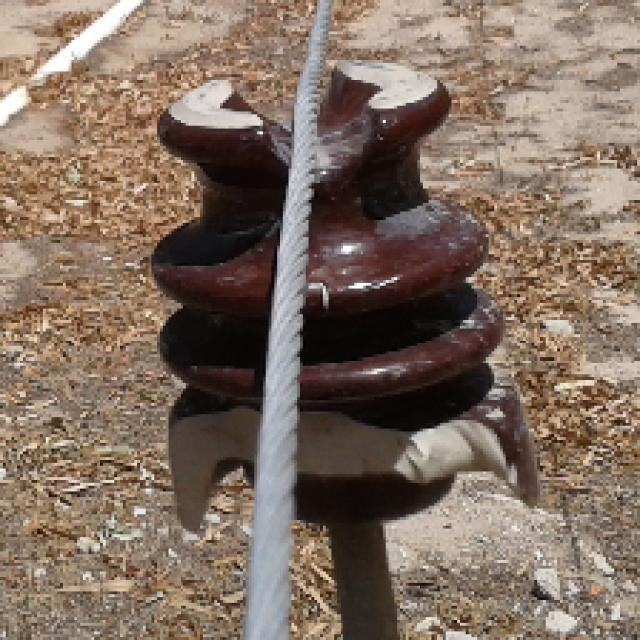

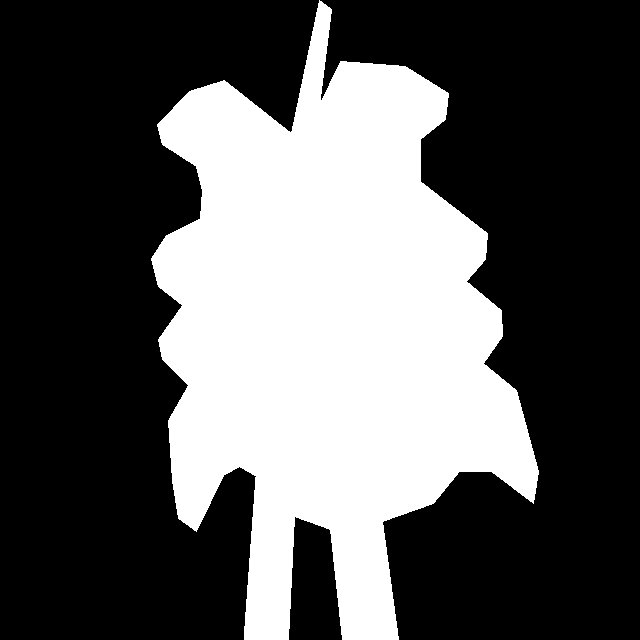

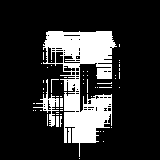

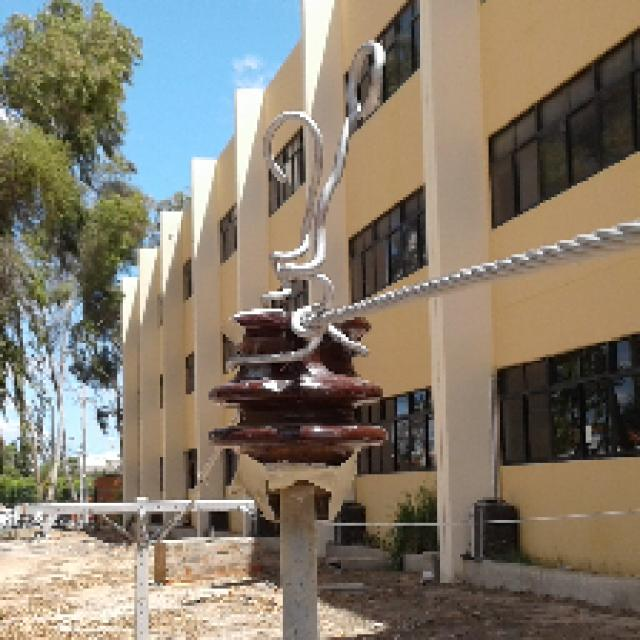

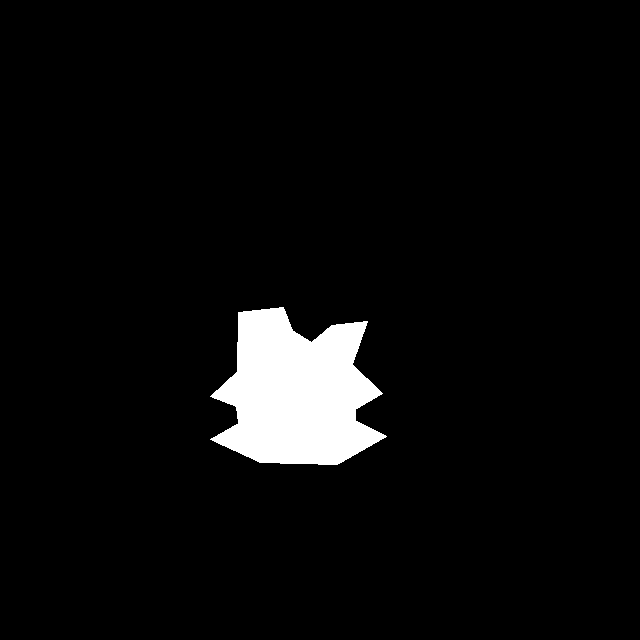

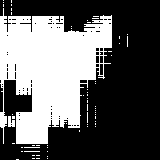

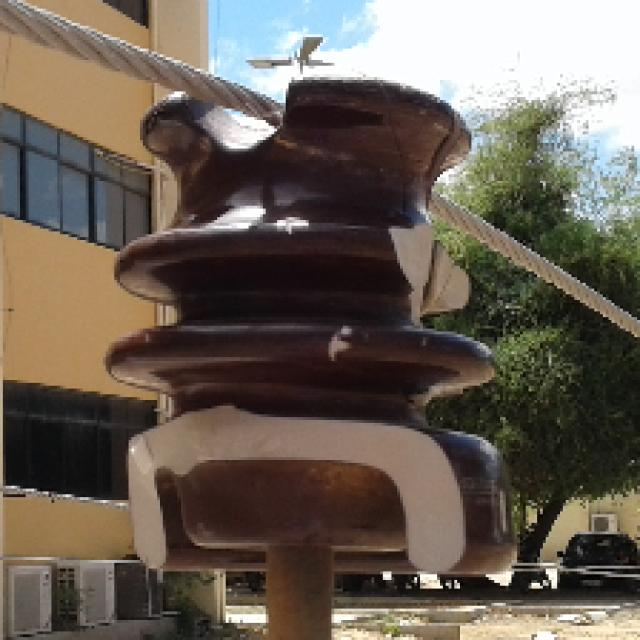

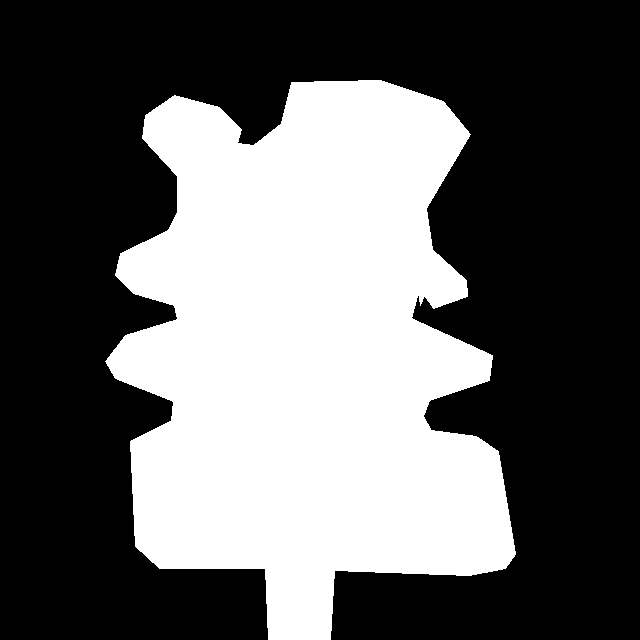

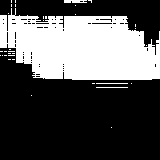

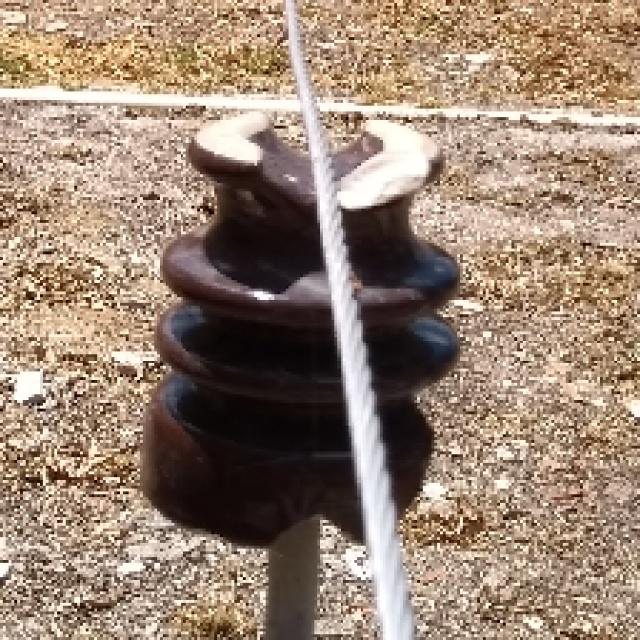

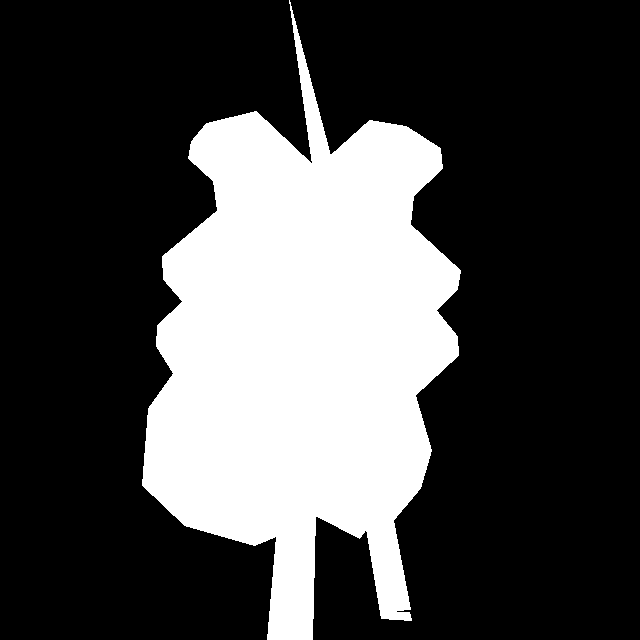

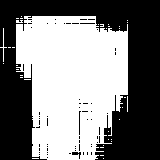

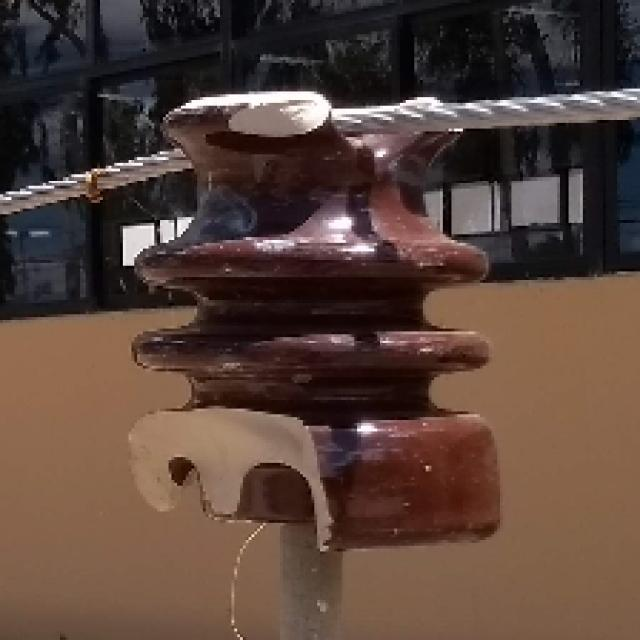

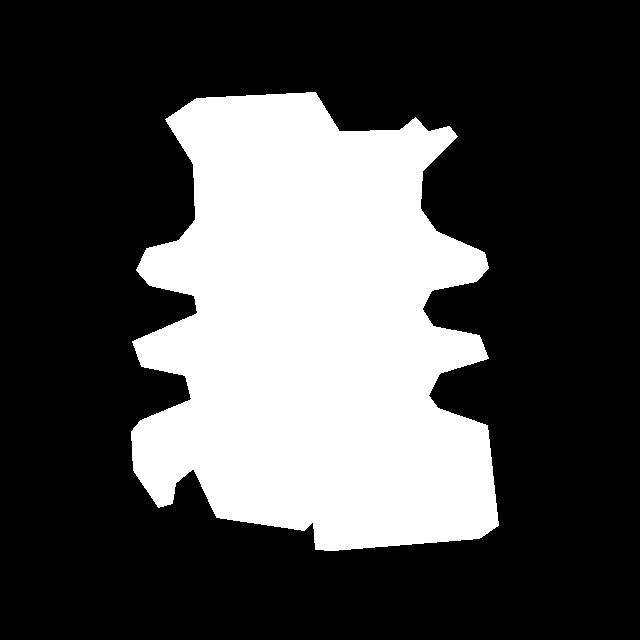

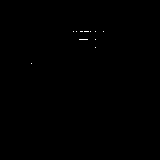

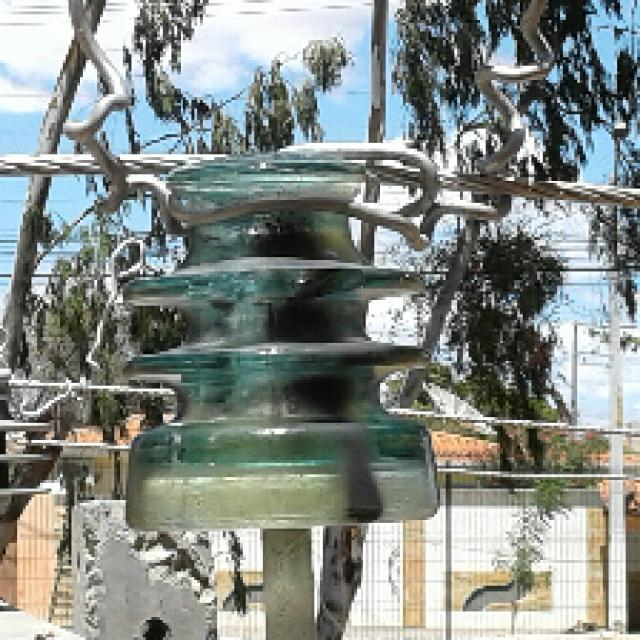

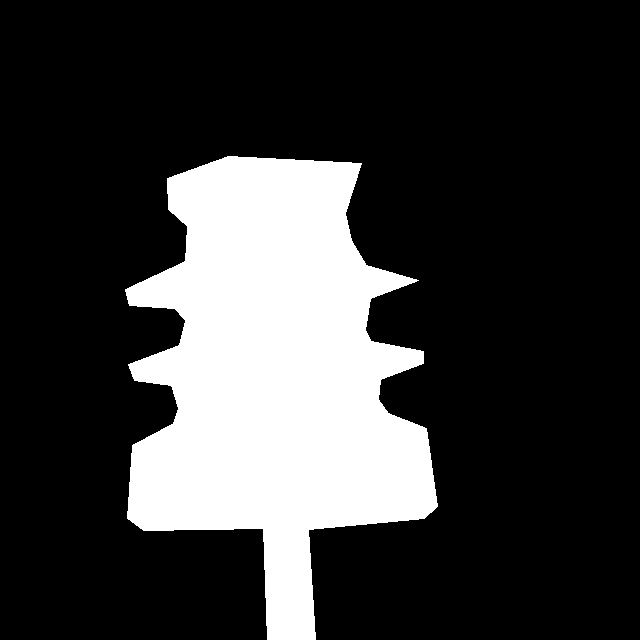

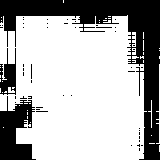

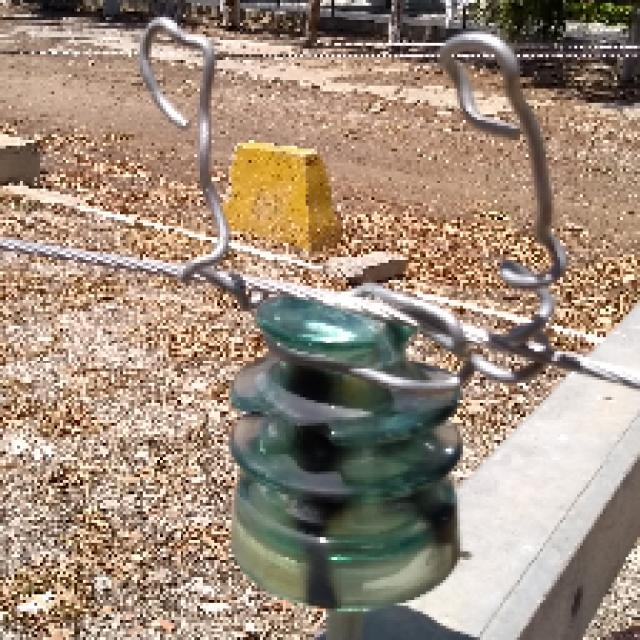

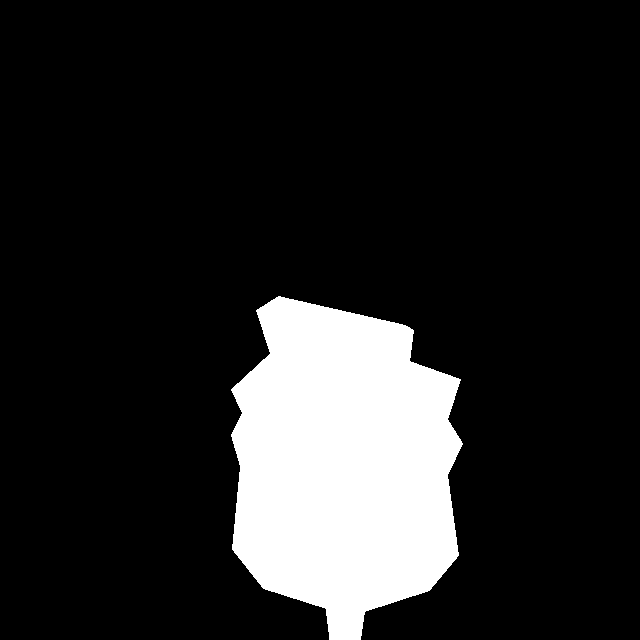

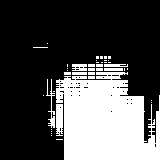

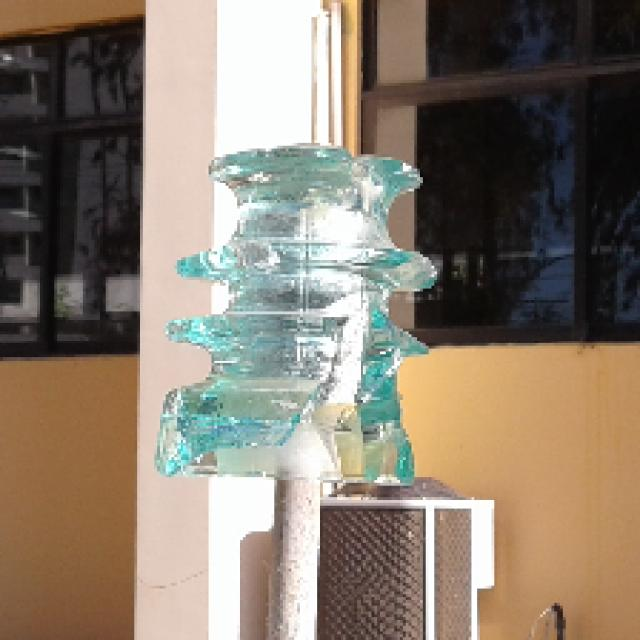

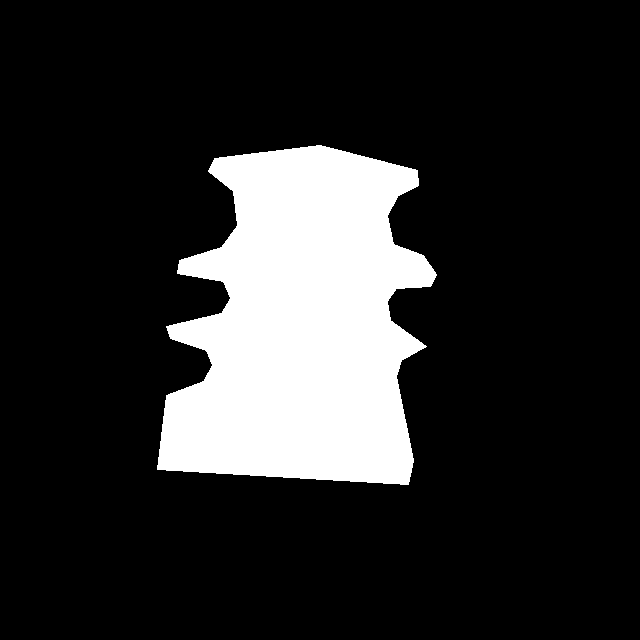

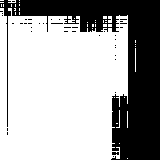

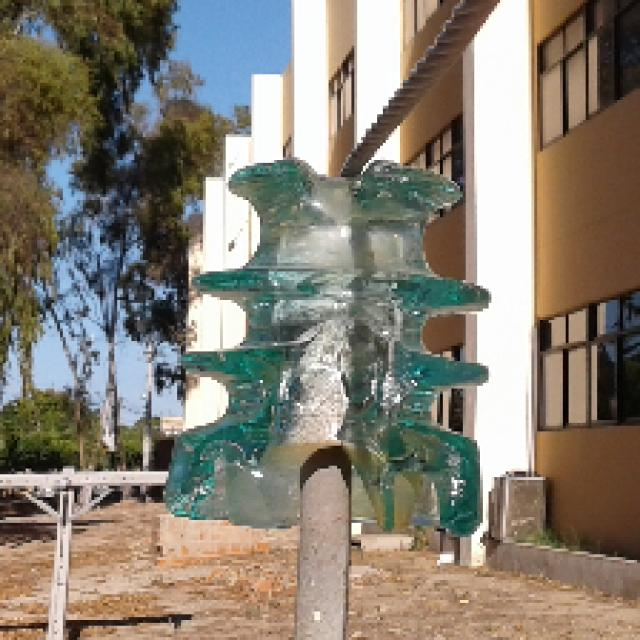

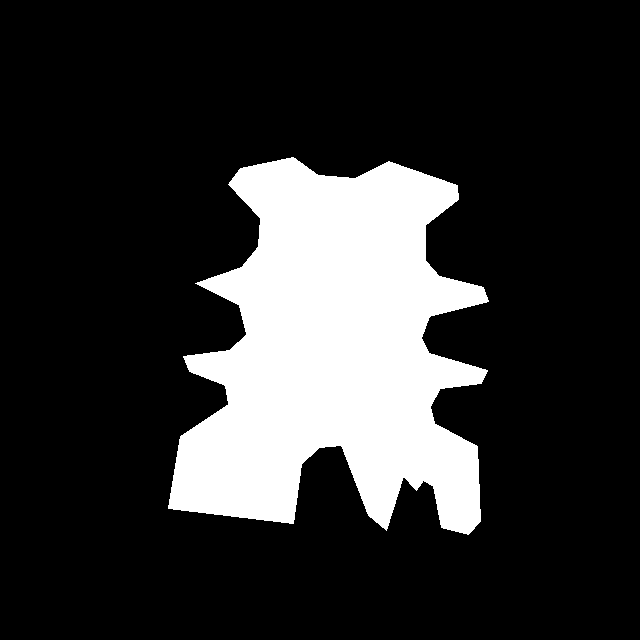

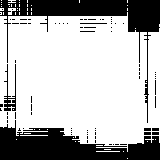

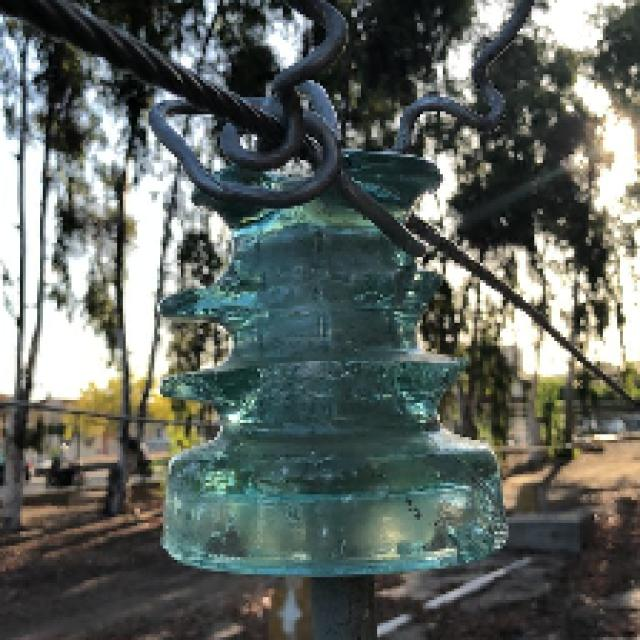

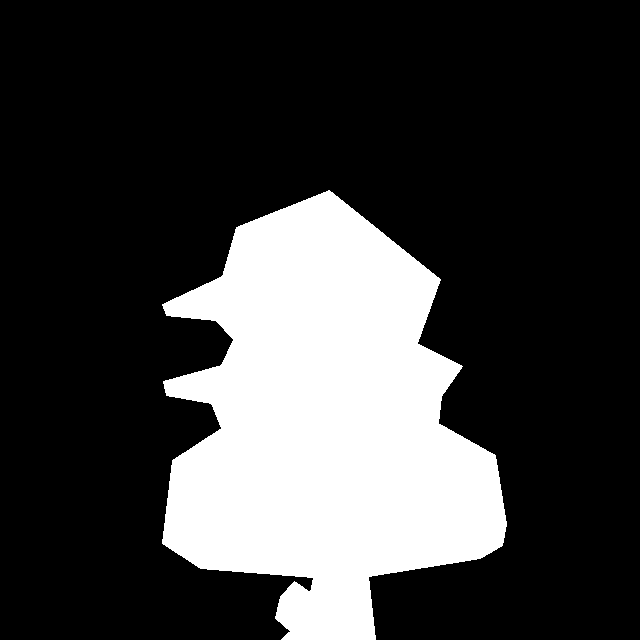

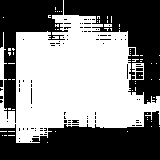

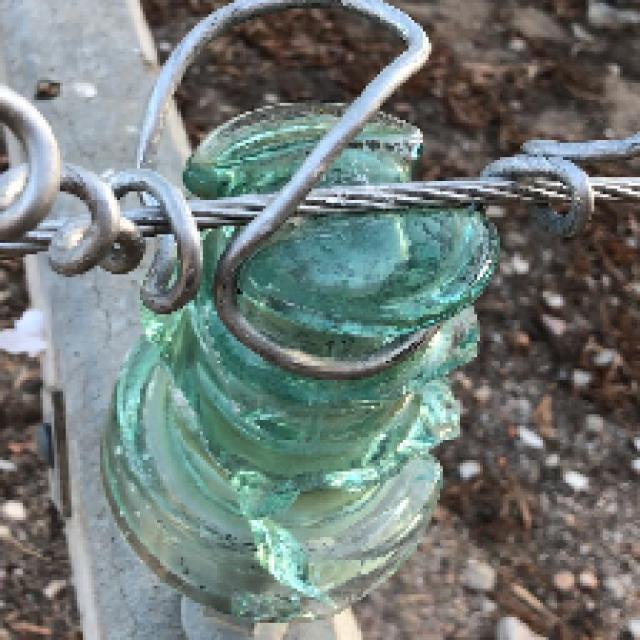

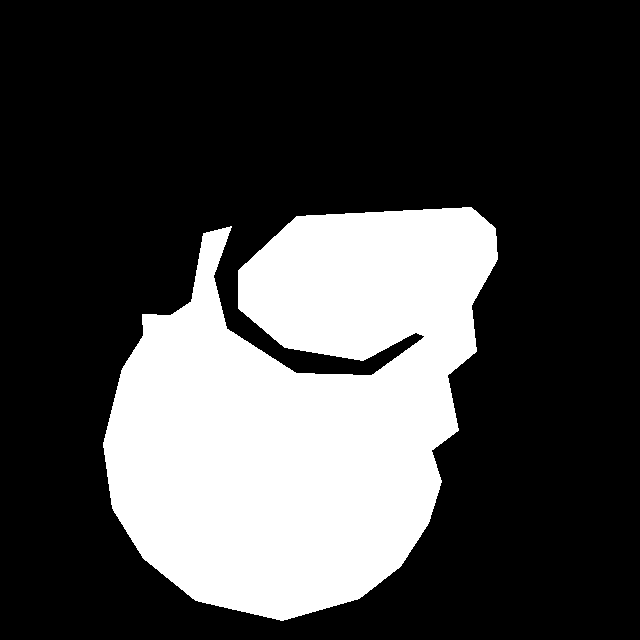

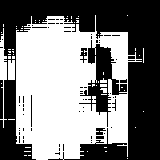

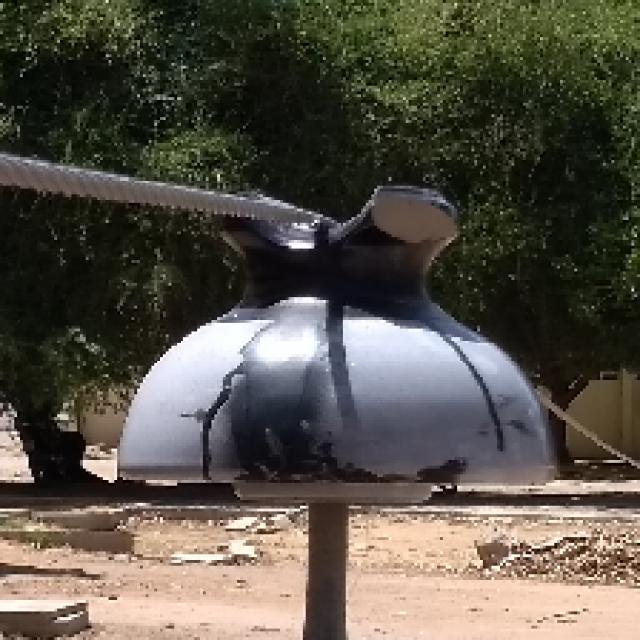

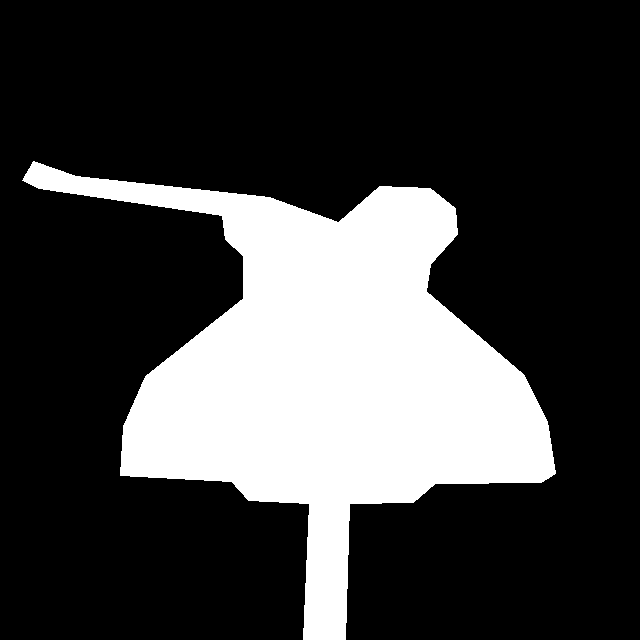

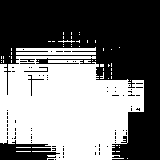

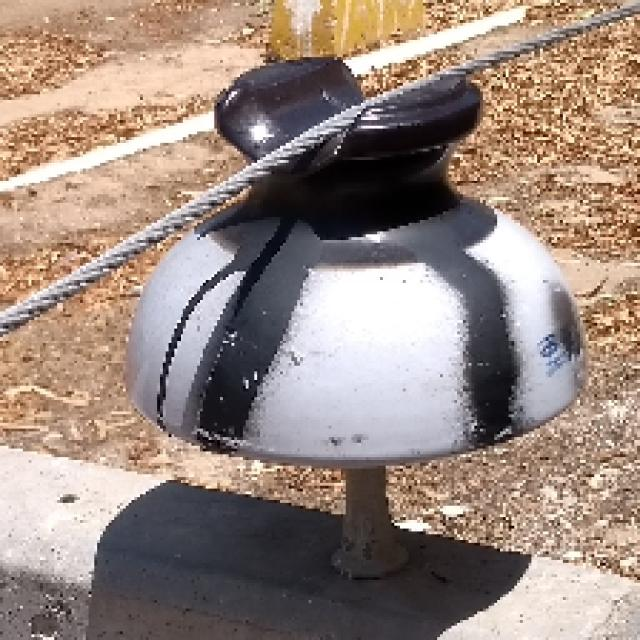

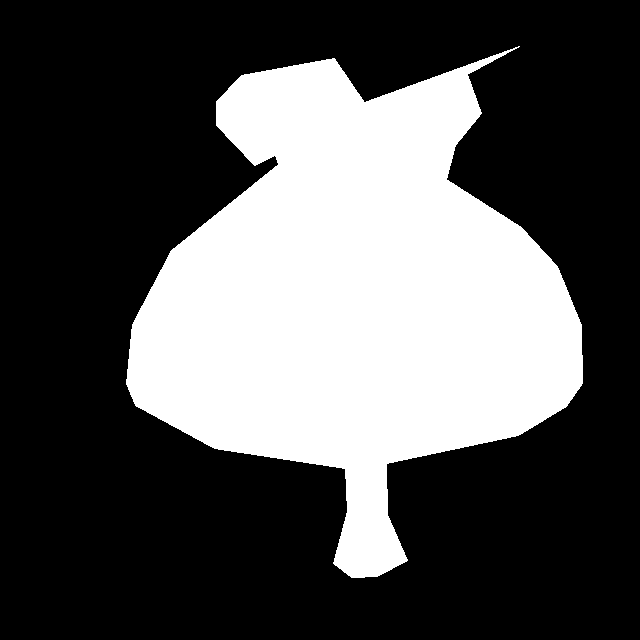

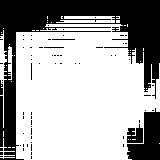

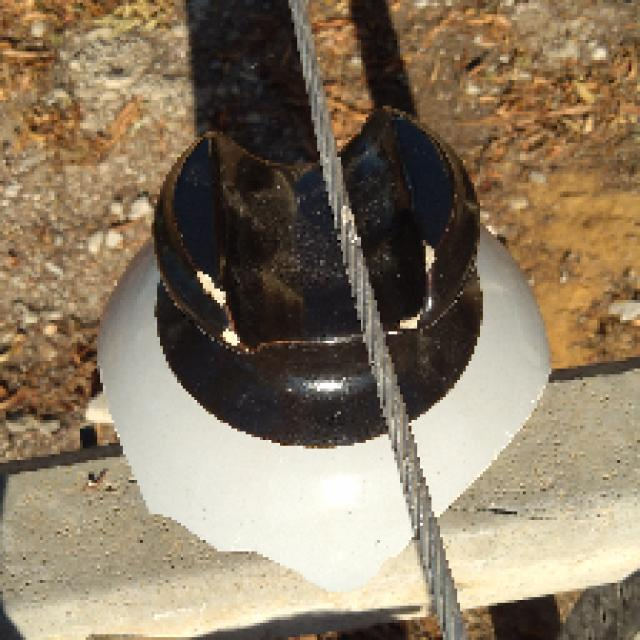

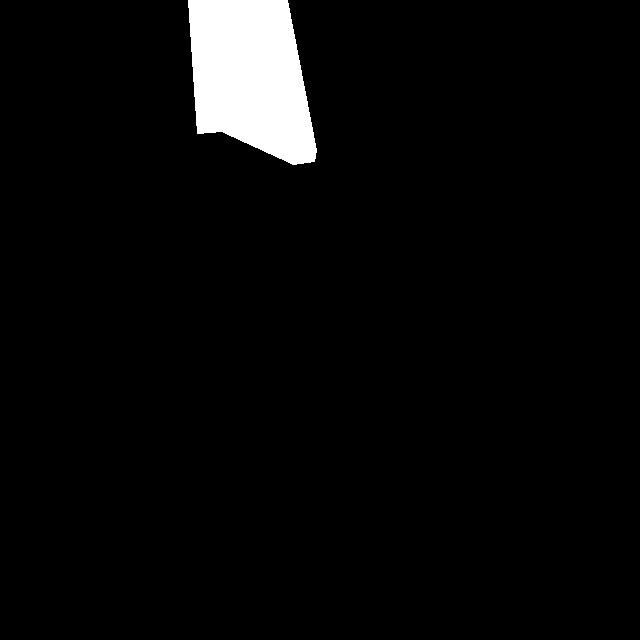

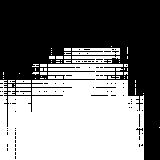

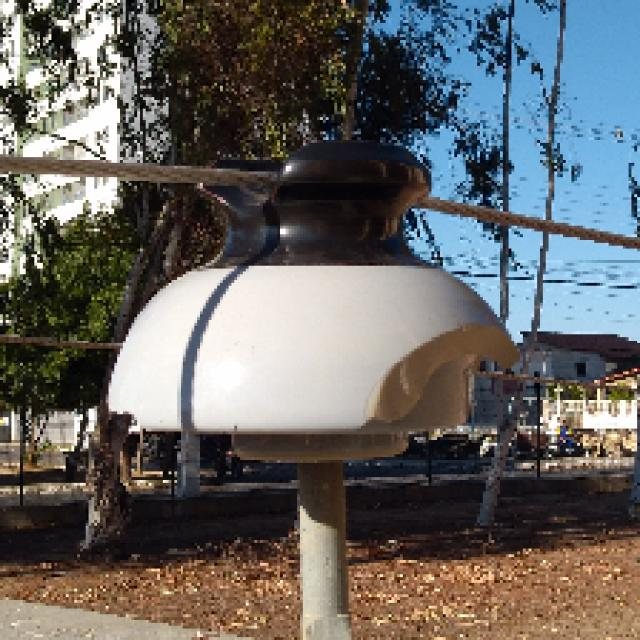

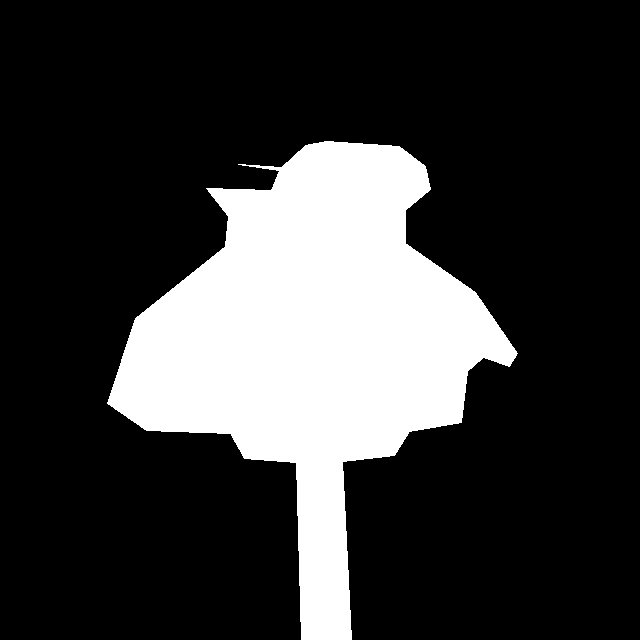

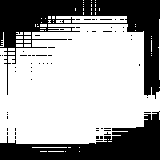

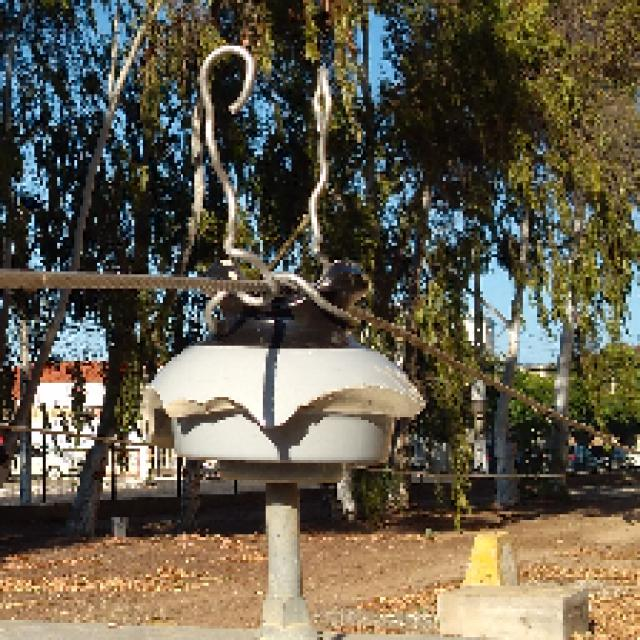

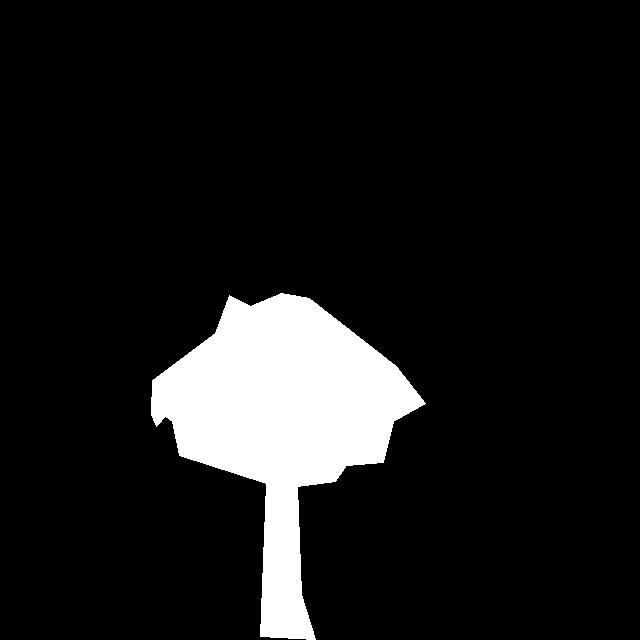

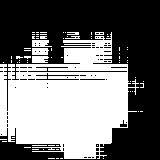

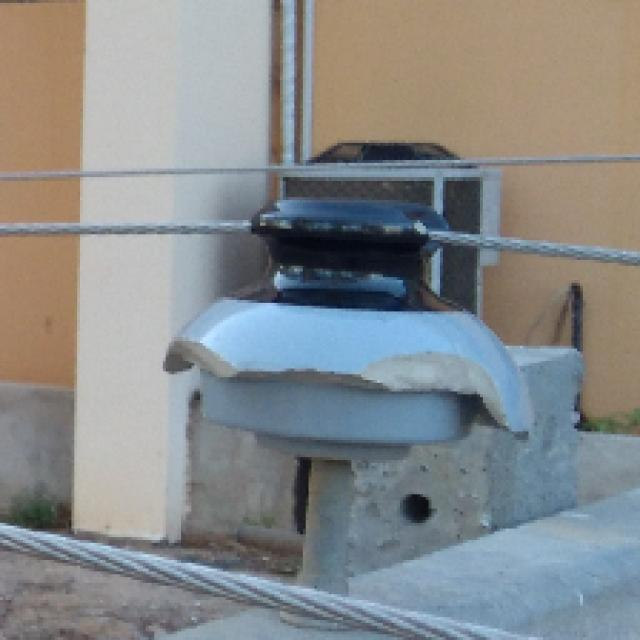

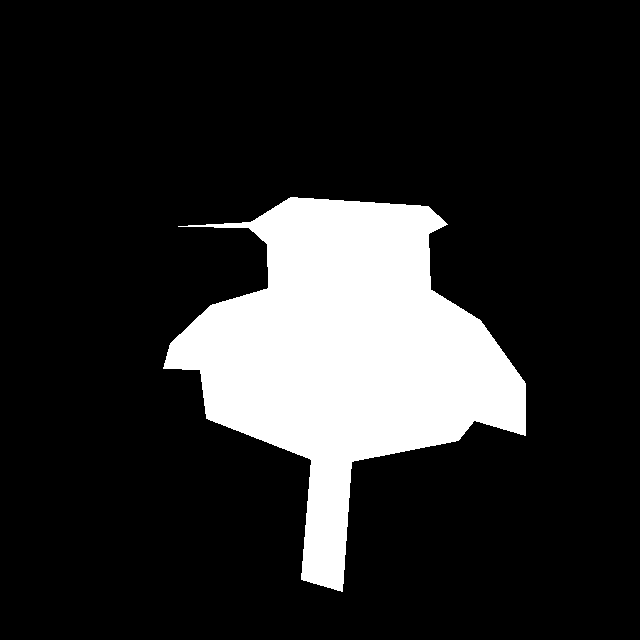

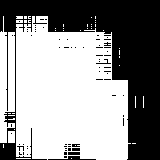

All masks have been saved to '/content/drive/MyDrive/Image_Segmentation_Insulator7/Mask'!


In [ ]:

# Generate predictions for the validation dataset
val_preds = model_archived.predict(valid_dataset)
end_time = time.time()

# Calculate the inference time
inference_time = end_time - start_time
print("Inference time: {} seconds".format(inference_time))

def display_and_save_mask(i,list_names_original):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    # Convert the mask to an image
    mask_img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    # Display the mask
    display(mask_img)

    # Save the mask image
    mask_img.save(os.path.join(output_dir_mask, f"mask_{list_names_original[i]}.png"))

# Loop through all validation images
for i in range(len(valid_input_paths)):
    display(Image(filename=valid_input_paths[i]))
    # Display ground-truth target mask
    img = ImageOps.autocontrast(load_img(valid_target_paths[i]))
    display(img)
    # Display and save the mask predicted by our model
    display_and_save_mask(i,list_names_original)

print(f"All masks have been saved to '{output_dir}'!")

# Find Contours of Grey Scale

In [502]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image

# Load the masked image and the original image
masked_image = img # Read as grayscale
# Convert the PIL Image to a NumPy array
masked_image = np.array(masked_image)

# Convert the masked image to grayscale
masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

original_image = (Image.open(valid_input_paths[i]))
# Find contours of white regions in the masked image
contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the bounding box of the largest contour
x, y, w, h = cv2.boundingRect(contours[0])

# Draw the bounding box on the original image
# Convert the PIL Image to a NumPy array
original_image = np.array(original_image)
bounding_box_image = cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the original image with the bounding box
cv2_imshow(bounding_box_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [503]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)
    return img


In [504]:
original_image.shape

In [505]:
img=display_mask(10)
import random
from PIL import Image, ImageOps
import numpy as np
import keras
resized_img = img.resize((640, 640), Image.Resampling.NEAREST)

In [506]:
original_image = (Image.open(valid_input_paths[i]))
original_image=np.array(original_image)
print(original_image.shape)
resized_image=np.array(resized_img)

resized_image=np.array(resized_image)
print(resized_image.shape)
display(Image.fromarray(resized_image))


Need to Extract the boundaries using find Countrours of Binary Image and save it in Contrours

In [ ]:
import cv2
from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab

class BoundingBox:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    def draw(self, image):
        cv2.rectangle(image, (self.x, self.y), (self.x + self.w, self.y + self.h), (0, 255, 0), 2)
i=10

for i in range(len(valid_dataset)):
# Load the original image
# Read the original image and the masked image
  original_image = (Image.open(valid_input_paths[i]))
  original_image = np.array(original_image)
  masked_image = resized_image # Read as grayscale
# Find contours in the masked image
  contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create bounding box objects and draw them on the original image
  bounding_boxes = []
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_box = BoundingBox(x, y, w, h)
    bounding_box.draw(original_image)
    bounding_boxes.append(bounding_box)

# Display the original image with bounding boxes
  cv2_imshow(original_image) # Pass only the image to cv2_imshow
#cv2.waitKey(0)
#cv2.destroyAllWindows()


In [ ]:
# Extracting items from the bounding_boxes list
def largest_bounding_box(bounding_boxes):
 area=0
 counter=0
 for item in bounding_boxes:
    w, h = item.w,item.h
    area_t=w*h# we must increase the counter in all cases so that we can keep on iterating
    if area_t>area:
      area=area_t
      index=counter
    counter=counter+1
 return index,area

counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)
counter,area_t
area_t
list_new_unet=[]
list_new_unet.append([bounding_boxes[counter].x,bounding_boxes[counter].y,bounding_boxes[counter].w,bounding_boxes[counter].h])


In [ ]:
list_new_unet

In [ ]:
def cropped_image_fn(original_image,bounding_boxes):
  counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)
  w,h=bounding_boxes[counter].w,bounding_boxes[counter].h
  a,b=bounding_boxes[counter].x,bounding_boxes[counter].y
  cropped_image= original_image[a:a+w,b:b+h]
  return cropped_image

In [ ]:

cropped_image=cropped_image_fn(original_image,bounding_boxes)

original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Plotting images side by side using Matplotlib
plt.figure(figsize=(10, 5))  # Set the figure size
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')  # Hide axes

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(cropped_image)
plt.title('Cropped Image')
plt.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot


In [ ]:
height = max(original_image.shape[0], cropped_image.shape[0])
original_image_resized = cv2.resize(original_image, (int(original_image.shape[1] * height / original_image.shape[0]), height))
cropped_image_resized = cv2.resize(cropped_image, (int(cropped_image.shape[1] * height / cropped_image.shape[0]), height))

# Plotting images side by side using Matplotlib
plt.figure(figsize=(10, 5))  # Set the figure size
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image_resized)
plt.title('Original Image_resized')
plt.axis('off')  # Hide axes

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(cropped_image_resized)
plt.title('Cropped Image_resized')
plt.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

In [ ]:
def display_and_save_mask(i,list_names_original):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    # Convert the mask to an image
    mask_img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    # Display the mask
    display(mask_img)

    # Save the mask image
    mask_img.save(os.path.join(output_dir, f"mask_{list_names_original[i]}.png"))
    return mask_img

# Save Masked Images using UNET Architecture

In [ ]:
def save_mask_from_model(list_names_original, model_name, valid_dataset, output_dir):  # Added valid_dataset and output_dir
    """
    Generates and saves masks from the model predictions for the validation dataset.

    Args:
        list_names_original: A list of original filenames for the validation images.
        model_name: The path to the saved model file.
        valid_dataset: The validation dataset.
        output_dir: The directory to save the generated masks.
    """
    model_archived = load_model(model_name)  # Load the model
    val_preds = model_archived.predict(valid_dataset)  # Predict on the validation dataset
    for i in range(len(valid_dataset)):  # Iterate through the validation dataset
        mask = np.argmax(val_preds[i], axis=-1)  # Get the predicted mask
        mask = np.expand_dims(mask, axis=-1)  # Expand dimensions for image conversion
        mask_img = ImageOps.autocontrast(keras.utils.array_to_img(mask))  # Convert to PIL Image
        mask_img.save(os.path.join(output_dir, f"mask_{list_names_original[i]}.png"))  # Save the mask
    return  # Return the last mask image

In [ ]:
save_mask_from_model(list_names_original=list_names_original,model_name='/content/oxford_segmentation.keras',valid_dataset=valid_dataset,output_dir=output_dir_mask)

In [ ]:
def display_and_save_mask2(i,list_names_original):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    # Convert the mask to an image
    mask_img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    # Save the mask image
    mask_img.save(os.path.join(output_dir, f"mask_{list_names_original[i]}.png"))
    return mask_img

# Loop through all validation images
for i in range(len(valid_dataset)):
    # Display ground-truth target mask
    img = ImageOps.autocontrast(load_img(valid_target_paths[i]))
    display(img)
    # Display and save the mask predicted by our model
    mask_img_t=display_and_save_mask(i,list_names_original)


In [ ]:
from PIL import Image
max_area=0
box=None
for box in bounding_boxes:
    x, y, width, height = box.x,box.y,box.w,box.h
    area = width * height
    if area > max_area:
        max_area = area
        max_box = box
max_area
print(max_box.x,max_box.y,max_box.w,max_box.h)
original=Image.open(valid_input_paths[i])
original=np.array( original)

original[max_box.x: max_box.x+max_box.w,max_box.y:max_box.y+max_box.h]


In [ ]:
counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)
w,h=bounding_boxes[counter].w,bounding_boxes[counter].h
print(w,h)
a,b=bounding_boxes[counter].x,bounding_boxes[counter].y
cropped_image= original_image[a:a+w,b:b+h]
cv2_imshow(cropped_image)

In [ ]:
def bounding_box_identification(masking,original_image):
  if not isinstance(masking, np.ndarray): # Use isinstance to check the type
    masking=np.array(masking)
  bounding_boxes = []
  countours,_=cv2.findContours(masking,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  for contour in countours:
    x,y,w,h=cv2.boundingRect(contour)
    bounding_box = BoundingBox(x, y, w, h)
    bounding_box.draw(original_image)
    bounding_boxes.append(bounding_box)
  cv2_imshow(original_image) # Pass only the image to cv2_imshow
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  return bounding_boxes


In [ ]:
len(bounding_boxes)

# Save Cropped Images or Segmented Images from Original Images

In [ ]:
list_new_unet

# Lets Create a Functon to Create a Dictionary of Predicted OutBound Boxes+ save images in a folder once they are cropped

In [ ]:
def save_cropped_all_images_model(valid_input_paths,valid_target_paths,output_dir_crop,model_name):
   list_names_original=name_extraction(valid_input_paths)
   model_archived = load_model(model_name)  # Load the model
   val_preds = model_archived.predict(valid_dataset)  # Predict on the validation dataset
   list_new_unet=[]# to identify all boxes coordinates for IOu
   for i in range(len(valid_target_paths)):  # Iterate through the validation dataset
        mask = np.argmax(val_preds[i], axis=-1)  # Get the predicted mask
        mask=cv2.resize(mask,(640, 640), interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1)  # Expand dimensions for image conversion
        # Ensure the mask has 3 dimensions before converting to PIL Image
        mask = mask.astype(np.uint8)
        mask_img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
        original_image = (Image.open(valid_input_paths[i]))# extract original image for cropping
        original_image = np.array(original_image)# convert into array
        # Display and save the mask predicted by our model
        if not isinstance(mask_img, np.ndarray): # Use isinstance to check the type
          mask_img=np.array(mask_img)
        bounding_boxes=bounding_box_identification(mask_img,original_image)# create List of Bounding Boxes
        counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)# find the area with loargest bounding box and note counter number
        list_new_unet.append([bounding_boxes[counter].x,bounding_boxes[counter].y,bounding_boxes[counter].w,bounding_boxes[counter].h])# extract eh bounding boxe associated to counter number
        cropped_image= cropped_image_fn(original_image,bounding_boxes)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        cropped_image_pil = ImageOps.autocontrast(Image.fromarray(cropped_image))
        cropped_image_pil.save(os.path.join(output_dir_crop, f"cropped_image_{list_names_original[i]}.png"))
   return dict(zip(list_names_original,list_new_unet))

In [ ]:
output_dir_test_crop='/content/drive/MyDrive/Image_Segmentation/output_dir/test_crop'
import os
os.makedirs(output_dir_test_crop, exist_ok=True)
clear_output_directory(output_dir_test_crop)
predicted_box_u_net=save_cropped_all_images_model(valid_input_paths=valid_input_paths,valid_target_paths=valid_target_paths,output_dir_crop=output_dir_test_crop,model_name='/content/oxford_segmentation.keras')

In [ ]:
list_new_unet

In [ ]:
for i in range(len(valid_dataset)):
    # Display ground-truth target mask
    print(i)
    img = ImageOps.autocontrast(load_img(valid_target_paths[i]))
    display(img)

In [ ]:
valid_dataset


# Save Masked Images after cropping

# Optimimizer to find Ideal Optiizer

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def train_model_with_optimizer_and_output(model, optimizers, learning_rates, epochs_list, train_dataset, valid_dataset):
    results = []
    best_model = None
    best_val_loss = float('inf')
    best_learning_rate = None
    best_epochs = None
    history_dict={}
    num_classes=2
    im_size=(160,160)
    for lr in learning_rates:
        for epochs in epochs_list:
          for item in optimizers:
            model = get_model(img_size, num_classes)
            model.compile(
                optimizer=item(lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            callbacks = [
                keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
            ]
            history = model.fit(
                train_dataset,
                epochs=epochs,
                validation_data=valid_dataset,
                callbacks=callbacks,
                verbose=0
            )
            val_loss = history.history['val_loss'][-1]  # Assuming loss is named 'loss' in the history and last value would be last epoch value
            if val_loss < best_val_loss:
                best_val_loss=val_loss
                best_learning_rate = lr
                best_epochs = epochs
                best_model = model
                history_dict = history.history
    results_df = pd.DataFrame({'Learning Rate': best_learning_rate, 'Epochs': best_epochs, 'Val_Loss': val_loss}, index=[0])
    plt.plot(history_dict['loss'], label='train_loss')
    plt.plot(history_dict['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return results_df, best_model


In [ ]:
def train_model_with_optimizer_and_output2(model, optimizers, learning_rates, epochs_list, train_dataset, valid_dataset):
    results = []
    img_size=(160,160)
    num_classes=2
    for lr in learning_rates:
        for epochs in epochs_list:
            for item in optimizers:
                model = get_model(img_size, num_classes)
                model.compile(
                    optimizer=item(lr),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )
                callbacks = [
                    keras.callbacks.ModelCheckpoint("model_checkpoint.keras", save_best_only=True)
                ]
                history = model.fit(
                    train_dataset,
                    epochs=epochs,
                    validation_data=valid_dataset,
                    callbacks=callbacks,
                    verbose=0
                )
                val_loss = history.history['val_loss'][-1]
                results.append({'Learning Rate': lr, 'Epochs': epochs, 'Optimizer': item, 'Val_Loss': val_loss, 'History': history,'MODEL': model})

    results_df = pd.DataFrame(results)

    # Find the best model based on validation loss
    best_model_index = results_df['Val_Loss'].idxmin()
    best_model_history = results_df.loc[best_model_index, 'History']
    best_model = results_df.loc[best_model_index, 'MODEL']

    # Plot the training history of the best model
    plt.plot(best_model_history.history['loss'], label='train_loss')
    plt.plot(best_model_history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return results_df, best_model

In [ ]:
#learning_rates = [1e-2,1e-3]  # Example list of learning rates to try
#epochs_list=[10,20]
#optimizers=[keras.optimizers.Adam, keras.optimizers.SGD]
#result_df,best_model=train_model_with_optimizer_and_output2(model,optimizers= optimizers, epochs_list=epochs_list, train_dataset=train_dataset, valid_dataset=valid_dataset,learning_rates=learning_rates)

In [ ]:
#result_df

In [ ]:
#result_df_markdown=result_df.loc[:,['Learning Rate','Epochs','Val_Loss']]
#result_df_markdown.to_excel('result_df_markdown.xlsx', index=False)

In [ ]:
# prompt: Using dataframe result_df_markdown:

# Create a markdown table from the dataframe
#markdown_table = result_df_markdown.to_markdown()

# Print the markdown table
#print(markdown_table)


In [ ]:
# @title Val_Loss

#from matplotlib import pyplot as plt
#result_df_markdown['Val_Loss'].plot(kind='line', figsize=(8, 4), title='Val_Loss')
#plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
#val_preds = best_model.predict(valid_dataset)
#end_time = time.time()

# Calculate the inference time
#inference_time = end_time - start_time
#print("Inference time: {} seconds".format(inference_time))

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)



# Display results for validation image #10
i = 10
# Display input image
display(Image.open(valid_input_paths[i]))
# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(valid_target_paths[i]))
display(img)
# Display mask predicted by our model
display_mask(i)

In [ ]:
# results = []
# best_model = None
# best_val_loss = float('inf')
# best_learning_rate = None
# best_epochs = None
# for lr in learning_rates:
#           for epochs in epochs_list:
#               model.compile(
#                   optimizer=optimizer(lr),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy']
#               )
#               callbacks = [
#                   keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
#               ]
#               history = model.fit(
#                   train_dataset,
#                   epochs=epochs,
#                   validation_data=valid_dataset,
#                   callbacks=callbacks,
#                   verbose=0
#               )
#               val_loss = history.history['val_loss'][-1]  # Assuming loss is named 'loss' in the history and last value would be last epoch value
#               if val_loss < best_val_loss:
#                   best_val_loss=val_loss
#                   best_learning_rate = lr
#                   best_epochs = epochs
#                   best_model = model
r#esults_df = pd.DataFrame({'Learning Rate': best_learning_rate, 'Epochs': best_epochs, 'Val_Loss': val_loss}, index=[0])

In [ ]:
# results = []
# best_model = None
# best_val_loss = float('inf')
# best_learning_rate = None
# best_epochs = None
# learning_rates = [1e-2]  # Example list of learning rates to try
# optimizers = [keras.optimizers.Adam]#list of optimizers
# for lr in learning_rates:
#           for item in optimizers:
#               model.compile(
#                   optimizer=item(lr=lr),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#               callbacks = [
#                   keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
#               ]
#               model.fit(
#                   train_dataset,
#                   epochs=epochs,
#                   validation_data=valid_dataset,
#                   callbacks=callbacks,
#                   verbose=2
#               )

In [ ]:
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# Check the shape and type of data yielded by the train_dataset
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)
    print("Image type:", images.dtype)
    print("Label shape:", labels.shape)
    print("Label type:", labels.dtype)

import random
random.seed(123)

start_time = time.time()
best_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)
end_time = time.time()

# Calculate the inference time
inference_time = end_time - start_time
print("Inference time: {} seconds".format(inference_time))

In [ ]:
# #import random
# #random.seed(123)

# #start_time = time.time()
# best_model.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=valid_dataset,
#     callbacks=callbacks,
#     verbose=2,
# )
# end_time = time.time()

# # Calculate the inference time
# inference_time = end_time - start_time
# print("Inference time: {} seconds".format(inference_time))

In [ ]:
#val_preds_best = best_model.predict(valid_dataset)
#end_time = time.time()

# Calculate the inference time
#inference_time = end_time - start_time
#print("Inference time: {} seconds".format(inference_time))

#def display_mask(i):
   # """Quick utility to display a model's prediction."""
   # mask = np.argmax(val_preds_best[i], axis=-1)
    #mask = np.expand_dims(mask, axis=-1)
    #img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    #display(img)



# Display results for validation image #10
#i = 10

# Display input image
#display(Image.open(valid_input_paths[i]))
# Display ground-truth target mask
#img = ImageOps.autocontrast(load_img(valid_target_paths[i]))
#display(img)
# Display mask predicted by our model
#display_mask(i)

# U-NET VARIANT ARCHITECTURE # Phase 2

In [ ]:
#U-NET ALGORITH
from keras.applications import ResNet50
ResNet50_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
ResNet50_model.summary()

In [ ]:
from tensorflow.keras.layers import UpSampling2D,Input,Conv2D,concatenate
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras import backend as K
# Get the output feature map from a specific layer in the ResNet model
resnet_output = ResNet50_model.get_layer('conv5_block3_3_conv').output  # Example layer name
print(resnet_output.shape)
# Since it is 7 by 7 and we want 224 by 224 we need a convolution such that 224/7=32
upsampled_resnet_output = UpSampling2D(size=(32, 32))(resnet_output)
# Convert the KerasTensor to a NumPy array
# Evaluate the tensor using Keras backend and convert it to a NumPy array
upsampled_resnet_output.shape
upsampled_resnet_output

In [ ]:
upsampled_resnet_output_np = tf.keras.backend.eval(upsampled_resnet_output)
upsampled_resnet_output_evaluated = K.eval(upsampled_resnet_output)
upsampled_resnet_output_np.shape
print(upsampled_resnet_output_np.dtype)

upsampled_resnet_output_np
upsampled_resnet_output_evaluated = K.eval(upsampled_resnet_output)
upsampled_resnet_output_evaluated

# The objective here at stake is the following:
# ResNet Algoirhtm works such that it extracts the weights of block wiht 2048 features but small Height and width of image and we have to convert it into 224,224,3. Upsampling can be done usind transppisiton conv 2d

We use Resnet to use the knowledge of previous images so that image segmentation can be better by knowing the feature dept that will help in image classification!!. So we have to take the knwoledge of Resnet Feature map and concatenate with existing images to that the feature map images can be helpful.

In [ ]:
input_img_paths[1][0]
output_img_paths[1][0]


# Creaton of Data Set- Train_Target Dataset for DirectImages and Creation of Trained Images for Masked Images

In [ ]:
img_size=(224,224)
batch_size=32
train_dataset_resnet=get_dataset(batch_size, img_size, input_img_paths=train_input_paths, target_img_paths=train_target_paths, max_dataset_len=None)

In [ ]:
 img_size=(224,224)
 batch_size=32
 y_train_dataset=get_dataset_target_only(img_size, target_img_paths=train_target_paths, max_dataset_len=None)
 y_train_dataset

In [ ]:
 img_size=(224,224)
 batch_size=32
 y_valid_dataset=get_dataset_target_only(img_size, target_img_paths=valid_target_paths, max_dataset_len=None)
 y_valid_dataset

In [ ]:
train_dataset_resnet

#Deep Learning Method using Transfer Learning and Auto Encoder Based Connector

In [ ]:
def get_model_load(input_img_path,target_img_path,target_size):
  input_img=tf.io.read_file(input_img_path)
  input_img=tf.io.decode_png(input_img,channels=3)
  input_img=tf.image.resize(input_img,target_size)
  input_img = tf.cast(input_img, tf.float32) / 255.0
  target_img = tf_io_read_file(target_img_path)
  target_img = tf_io_decode_png(target_img, channels=1)
  target_img = tf_image_resize(target_img, img_size, method="nearest")
  target_img = tf.cast(target_img, tf.float32) / 255.0
  target_img= tf.where(target_img > 0.5, 1, 0)
  target_img = tf.clip_by_value(target_img, 0, 1)
  resnet_output = ResNet50_model.get_layer('conv5_block3_out').output
  upsampled_resnet_output = UpSampling2D(size=(32, 32))(resnet_output)# upsampling by using 7
  modified_input  = Conv2D(3, (1, 1), activation='relu')(upsampled_resnet_output)# reducing the number of features by passing it through 3 filters which is number of channels
  modified_input_img = Concatenate()([input_img, upsampled_resnet_output])
  return modified_input_img,target_img

In [ ]:
# Get Upsamped Output
def get_resnet_upsampled_output():
  ResNet50_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
  resnet_output=ResNet50_model.get_layer('conv5_block3_out').output
  upsampled_resnet_output=UpSampling2D(size=(32,32))(resnet_output)
  upsampled_resnet_output_np = tf.keras.backend.eval(upsampled_resnet_output)
  upsampled_resnet_output_evaluated = K.eval(upsampled_resnet_output)
  return upsampled_resnet_output_evaluated


In [ ]:
def create_neural_network_model(input_shape):
    input_layer = Input(shape=input_.shape)
    conv_layer1 = Conv2D(3, (1, 1), activation='relu', padding='same')(input_layer)
    conv_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_layer1)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv_layer2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
up_sampled=get_resnet_upsampled_output()
shape1=up_sampled.shape[1:]
print(shape1)
def auto_encoder(data):

# Encoder
  input_img = Input(shape=data.shape[1:])# shape after up sampling the image from ResNet Model
  encoder_1=UpSampling2D(size=(32,32))(input_img)
  encoder = Conv2D(3, (1, 1), activation='relu', padding='same')(input_img)# We encode the model to 3 Filters which is our objective

# Decoder
  decoded = Conv2D(2048, (1, 1), activation='relu', padding='same')(encoder)# decode it back to 2048
  autoencoder = Model(input_img, decoded)
  return autoencoder


In [ ]:
get_dataset_encoder_only(batch_size=32, img_size=img_size, input_img_paths=train_input_paths, max_dataset_len=None)

Lets get X_train for Training data and a transformed X_train_valid data

In [ ]:
img_sizesize=(224,224)
batch_size=32
X_train=get_dataset_encoder_only(batch_size, img_size, input_img_paths=train_input_paths, max_dataset_len=None)
X_train# We have created a batch of test data that is of share 224,224,3
img_sizesize=(224,224)
batch_size=32
X_train=get_dataset_encoder_only(batch_size, img_size, input_img_paths=train_input_paths, max_dataset_len=None)
X_train_valid=get_dataset_encoder_only(batch_size, img_size, input_img_paths=valid_input_paths, max_dataset_len=None)
# Iterate over the dataset to extract the shape of a single batch
for batch in X_train.take(1):
    print(batch.shape)

# If you need the entire dataset as a NumPy array, you can use:
# import numpy as np
# X_train_np = np.concatenate([batch.numpy() for batch in X_train], axis=0)
# print(X_train_np.shape)


In [ ]:
X_train

In [ ]:
# Check if X_train is empty
is_empty = len(list(X_train.take(3))) == 0
print("Is X_train empty?", is_empty)




In [ ]:
def auto_encoder(data):

# Encoder
  input_img = Input(shape=data.shape[1:])# shape after up sampling the image from ResNet Model
  encoder_1=UpSampling2D(size=(32,32))(input_img)
  encoder = Conv2D(3, (1, 1), activation='relu', padding='same')(encoder_1)# We encode the model to 3 Filters which is our objective
# Decoder
  decoded2 = Conv2D(2048, (2, 2), activation='relu', padding='same',strides=32)(encoder)  # Convert to 7x7x2048
  autoencoder = Model(input_img, decoded2)
  return autoencoder

In [ ]:
224/7

# ResNet obtained Detailed Feature Map obtained from Transfer Learning for X_Train and X_train_valid data

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False)  # Load pre-trained ResNet50 model without the fully connected layers

# Extract output of Block 5 (res5c_branch2c) layer
block5_output = resnet_model.get_layer('conv5_block3_out').output

# Create a new model to obtain the output of the Block 5 layer
resnet_block5_model = Model(inputs=resnet_model.input, outputs=block5_output)
resnet_block5_output = []
for batch in X_train:
    resnet_block5_output.append(resnet_block5_model.predict(batch))
resnet_block5_output_valid=[]# the resnet equivalent for images in Validation data
for item in X_train_valid:
    resnet_block5_output_valid.append(resnet_block5_model.predict(item))


In [ ]:
type(resnet_block5_output)

In [ ]:
resnet_block5_output = np.concatenate(resnet_block5_output, axis=0)
print(resnet_block5_output.shape)

In [ ]:
resnet_block5_output.shape

In [ ]:
model=auto_encoder(resnet_block5_output)
model.summary()

In [ ]:
model=auto_encoder(resnet_block5_output)
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model3=model.fit(resnet_block5_output, resnet_block5_output, epochs=10, batch_size=32)

In [ ]:
model3.history

In [ ]:
X_Train_reformed=model.predict(resnet_block5_output)

In [ ]:
X_Train_reformed.shape

In [ ]:
output_layer=model.layers[-2].output
output_layer
def get_model_new(model):
   ouput_layer=model.layers[-2].output
   model_new=Model(inputs=model.input,outputs=output_layer)
   return model_new
M_ENCODING=get_model_new(model)
M_ENCODING.summary()

Converstion of X_TRAIN AND X_TRAIN_VALID FROM 7,7,2048 TO 224,224,3 shape

In [ ]:
best_representation = M_ENCODING.predict(resnet_block5_output)#  Convert 7,7,2048 of X_train
best_representation_valid=M_ENCODING.predict(resnet_block5_output_valid)# convert 7,7,2048 of X_valid


In [ ]:
best_representation.shape
# But i need to r

dataset = tf.data.Dataset.from_tensor_slices(best_representation)
batched_dataset = dataset#  converting into dataset from np array
dataset_valid=tf.data.Dataset.from_tensor_slices(best_representation_valid)
batched_dataset_valid=dataset_valid
#converting batched data set of X_valid,X_TRAIN In dataset format

In [ ]:
batched_dataset_valid

In [ ]:
batched_dataset

# We need to Ensure Tensor Set Dataset obtained from Resnet Representation and y_train needs to be of same shape. Hence we did comparison

In [ ]:
dataset_new_resnet_target=dataset.zip(batched_dataset,y_train_dataset)
batched_train_target_dataset=dataset_new_resnet_target.batch(32)
batched_train_target_dataset

In [ ]:
import numpy as np
y_pred=np.empty((0, 224, 224,1 ))

# Assuming dataset_new_resnet_target is your batched dataset
for x,y in batched_train_target_dataset.take(3):
  y_pred=np.concatenate((y_pred,y),axis=0)



In [ ]:
y_pred.shape

In [ ]:
for x,y in batched_train_target_dataset.take(3):
  print(x.shape)
  print(y.shape)

In [ ]:
dataset_new_resnet_target_valid=dataset_valid.zip(batched_dataset_valid,y_valid_dataset)# Validation set of transformed Resnet features and Masked Y_DATA
batched_valid_target_dataset=dataset_new_resnet_target_valid.batch(32)
batched_valid_target_dataset
num_classes=2
img_size=(224,224)

In [ ]:
def get_model_new(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    ### [First half of the network: downsampling inputs] ###
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="valid")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model




In [ ]:
import os
mode_file_name="Optimized_Hypertuned_Model.keras"
model_directory = "/content/drive/MyDrive/Image_Seg/models"  # Adjust 'MyDrive' if necessary, or use the full path where the model was saved
model_path_transfer = os.path.join(model_directory, mode_file_name)

# Print the model path to verify it's correct
print(f"Looking for model at: {model_path_transfer}")
model_new_transfer = get_model_new(img_size, num_classes)
print(model_new_transfer.summary())


model_new_transfer.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=model_path_transfer, save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50


In [ ]:
import os
import keras
from keras.models import load_model
from keras import layers


mode_file_name = "Optimized_UNET_variant.keras"
model_directory = os.getcwd()  # Save in the current working directory
model_path_var = os.path.join(model_directory, mode_file_name)

# Print the model path to verify it's correct
print(f"Saving/Looking for model at: {model_path_var}")

# ... (Rest of your code to create and compile the model) ...

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=model_path_var, save_best_only=True)
]


print(model_directory)

model_new_transfer = get_model_new(img_size, num_classes)
print(model_new_transfer.summary())


model_new_transfer.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=model_path_var, save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50

In [ ]:
model_new_transfer.fit(
    batched_train_target_dataset,
    epochs=epochs,validation_data=
    batched_valid_target_dataset,
    callbacks=callbacks,
    verbose=2)


In [ ]:
model_transfer_archived=load_model(model_path_var)


In [ ]:
batched_train_target_dataset



In [ ]:
#val_preds = model_transfer_archived.predict(batched_dataset_valid)


In [ ]:
batched_dataset_valid
batched_valid_target_dataset


In [ ]:
valid_length = val_preds.shape[0]
img_all = np.empty([valid_length, val_preds.shape[1], val_preds.shape[2]])
for j in range(valid_length):
    mask = np.argmax(val_preds[j], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    img_all[j] = img

Batched Vald_target dataset is zipping of X_vALID AND Y_vALID. HENCE- results should be same if we use model.predict(x_valid) or model.predict(Dataset_Valid)

In [ ]:
val_preds = model_transfer_archived.predict(batched_valid_target_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)
    return img


# Display results for validation image #10
i = 10
# Display input image
display(Image.open(valid_input_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(valid_target_paths[i]))
display(img)
print(img.size)
# Display mask predicted by our model
display_mask(i)

In [ ]:
val_preds[0].shape

In [ ]:
masked_image=display_mask(10)
masked_image2=np.array(masked_image)
masked_image2=cv2.resize(masked_image2,(640, 640), Image.Resampling.NEAREST)# since original shape is 640,640
masked_image2.shape

def bounding_box_identification(masking,original_image):
  countours,_=cv2.findContours(masking,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)# mask around the image
  for contour in countours:
    x,y,w,h=cv2.boundingRect(contour)
    bounding_box = BoundingBox(x, y, w, h)# bounding boxes
    bounding_box.draw(original_image)# draw around the image of interest
    bounding_boxes.append(bounding_box)# bounding box
  cv2_imshow(original_image) # Pass only the image to cv2_imshow
  cv2.waitKey(0)
  cv2.destroyAllWindows()
masked_image=display_mask(10)
masked_image2=np.array(masked_image)
masked_image2=cv2.resize(masked_image2,(640, 640), Image.Resampling.NEAREST)# since original shape is 640,640
masked_image2.shape

def bounding_box_identification(masking,original_image):
  countours,_=cv2.findContours(masking,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)# mask around the image
  for contour in countours:
    x,y,w,h=cv2.boundingRect(contour)
    bounding_box = BoundingBox(x, y, w, h)# bounding boxes
    original_image=np.array(original_image)
    bounding_box.draw(original_image)# draw around the image of interest
    bounding_boxes.append(bounding_box)# bounding box
  cv2_imshow(original_image) # Pass only the image to cv2_imshow
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  return bounding_boxes
i=10
bounding_boxes=bounding_box_identification(masked_image2,original_image=Image.open(valid_input_paths[i]))

In [ ]:
counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)
bounding_boxes[counter].x,bounding_boxes[counter].y,bounding_boxes[counter].w,bounding_boxes[counter].h
i=10
original_im=Image.open(valid_input_paths[i])
OR=np.array(original_im)
OR[bounding_boxes[counter].x :bounding_boxes[counter].x+bounding_boxes[counter].w,bounding_boxes[counter].y:bounding_boxes[counter].y+bounding_boxes[counter].h]

In [ ]:
list_new_unet_tranfer=[]
list_new_unet_tranfer.append([bounding_boxes[counter].x,bounding_boxes[counter].y,bounding_boxes[counter].w,bounding_boxes[counter].h])
list_new_unet_tranfer

In [ ]:
original_image[bounding_boxes[counter].x :bounding_boxes[counter].x+bounding_boxes[counter].w,bounding_boxes[counter].y:bounding_boxes[counter].y+bounding_boxes[counter].h]

In [ ]:
masked_image = resized_image # Read as grayscale

# Find contours in the masked image
contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create bounding box objects and draw them on the original image
bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_box = BoundingBox(x, y, w, h)
    bounding_box.draw(original_image)
    bounding_boxes.append(bounding_box)

# Display the original image with bounding boxes
cv2_imshow(original_image) # Pass only the image to cv2_imshow
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
len(valid_target_paths)

In [ ]:
output_dir_crop_var='/content/drive/MyDrive/Image_Segmentation/output_dir/var_crop'
os.makedirs(output_dir_crop_var, exist_ok=True)
clear_output_directory(output_dir_crop_var)



val_preds = model_archived.predict(batched_valid_target_dataset)
mask = np.argmax(val_preds[i], axis=-1)  # Get the predicted mask
mask = np.expand_dims(mask, axis=-1)  # Expand dimensions for image conversion
mask.shape
import cv2


def save_cropped_all_images_model(valid_input_paths,valid_target_paths,output_dir_crop,model_name,batched_valid_target_dataset):
   list_names_original=name_extraction(valid_input_paths)
   model_archived = load_model(model_name)  # Load the model
   val_preds = model_archived.predict(batched_valid_target_dataset) # Predict on the validation dataset after resizing images to 160x160
   list_new_unet_transfer=[]# Initiate empty list
   for i in range(len(valid_target_paths)):  # Iterate through the validation dataset
        print(f"Processing image {i + 1} out of {len(valid_target_paths)}")
        mask = np.argmax(val_preds[i], axis=-1)  # Get the predicted mask
        mask = np.expand_dims(mask, axis=-1)  # Expand dimensions for image conversion
        mask=cv2.resize(mask,(640, 640), interpolation=cv2.INTER_NEAREST)
               # Ensure the mask has 3 dimensions before converting to PIL Image
        mask = mask.astype(np.uint8)
        if mask.ndim == 2:  # Check if the mask is 2D
            mask = np.expand_dims(mask, axis=-1)
        #mask_img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
        if not isinstance(mask, np.ndarray):
             mask_img = np.array(mask)
        original_image = (Image.open(valid_input_paths[i]))# extract original image for cropping
        original_image = np.array(original_image)# convert into array
        # Display and save the mask predicted by our model
        mask_img=mask
        bounding_boxes=bounding_box_identification(mask_img,original_image)# create List of Bounding Boxes
        counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)# find the area with loargest bounding box and note counter number
        list_new_unet_transfer.append([bounding_boxes[counter].x,bounding_boxes[counter].y,bounding_boxes[counter].w,bounding_boxes[counter].h])
        cropped_image= cropped_image_fn(original_image,bounding_boxes)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        cropped_image_pil = ImageOps.autocontrast(Image.fromarray(cropped_image))
        cropped_image_pil.save(os.path.join(output_dir_crop, f"cropped_image_{list_names_original[i]}.png"))
   return dict(zip(list_names_original,list_new_unet_transfer))

# we are returning a list of imags with Predicted  Bounding Boxes

In [ ]:
val_preds = model_archived.predict(batched_valid_target_dataset)
val_preds.shape

In [ ]:
predicted_truth_dict=save_cropped_all_images_model(valid_input_paths=valid_input_paths,valid_target_paths=valid_target_paths,output_dir_crop=output_dir_crop_var,model_name=model_path_var,batched_valid_target_dataset=batched_valid_target_dataset)

Traditional K Clustering with K=2 -This is not successful

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf

# Assuming you have a tf.dataset.Dataset object called 'image_dataset'

# Convert the images in the dataset to a NumPy array
image_list = []
for image in X_train:
    image_list.append(image.numpy())


# Reshape the images if needed
# images = images.reshape(images.shape[0], -1)  # Only reshape if your images are not already flattened

# Perform k-means clustering directly on the 2D image data
n_clusters = 5  # Number of clusters

In [ ]:
X_train

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf

# Assuming you have a tf.dataset.Dataset object called 'image_dataset'

# Convert the images in the dataset to a NumPy array, ensuring consistent dimensions
image_list = []
for image in X_train:
    image_np = image.numpy()
    if len(image_list) > 0:  # Check if the list is not empty
        if image_np.shape != image_list[0].shape:
            print("Warning: Image shapes are inconsistent. Skipping image.")
            continue  # Skip images with different shapes
    image_list.append(image_np)

# Convert the list to a NumPy array (now with consistent shapes)
image_array = np.array(image_list)

In [ ]:
image_array.shape

In [ ]:
images_reshaped = image_array.reshape(-1, image_array.shape[2], image_array.shape[3], image_array.shape[4])
images_reshaped.shape

In [ ]:
# Loop through each image
start_time = time.time()
segmented_images = []
for image_data in images_reshaped:
    # Reshape the image data to a 2D array
    pic_n = np.reshape(image_data, (-1, images_reshaped.shape[-1]))# reshape into (#number of Pixels,3)# number of Pixels and channels
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
    # Assign each pixel to the nearest cluster center
    pic2show = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape pic2show back to the original image shape
    segmented_image = np.reshape(pic2show, (image_data.shape[0], image_data.shape[1], image_data.shape[2]))

    # Append the segmented image to the list
    segmented_images.append(segmented_image)
end_time=time.time()
# Calculate the final time spent
final_time = end_time - start_time

# Print the result
print("Final Time Spent is ", final_time)

In [ ]:
final=create_binary_image(segmented_image,threshold_value=0.82)
plt.imshow(final,cmap='gray')

In [ ]:
len(segmented_images)
for  item in range(len(segmented_images)):
    binary=create_binary_image(segmented_images[item],threshold_value=0.6)
    plt.imshow(binary,cmap='gray')
    plt.show()

#Measurement of Intersection of Union

In [ ]:
for item in X_train_valid:
  print(item.shape)

In [ ]:
X_train_valid
num_elements = len(list(X_train_valid))

print(f"Number of elements in the dataset: {num_elements}")


In [ ]:
X_train_valid
tenth_item = next(iter(X_train_valid.take(1)))
tenth_valid_item=tenth_item[10].numpy()

In [ ]:
print("Thenth Valid item")
plt.imshow(tenth_valid_item)


# Convert the Image to H*W,3

In [ ]:
new_10th_item=tenth_valid_item.reshape(-1 ,tenth_valid_item.shape[-1]).copy()

In [ ]:
new_10th_item.shape

In [ ]:
K_means_10 = KMeans(n_clusters=2, random_state=0).fit(new_10th_item)
    # Assign each pixel to the nearest cluster center
pic2show = K_means_10.cluster_centers_[K_means_10.labels_]

    # Reshape pic2show back to the original image shape
segmented_image = np.reshape(pic2show, (image_data.shape[0], image_data.shape[1], image_data.shape[2]))

In [ ]:
y_hat_image_ten=create_binary_image(segmented_image,threshold_value=0.6)
plt.imshow(y_hat_image_ten,cmap='gray')

In [ ]:
y_hat_image_ten.shape

In [ ]:
resized_image = cv2.resize(original_image, (224, 224), interpolation=cv2.INTER_LINEAR)
resized_image.shape

In [ ]:
# Convert the image to the correct data type
y_hat_image_ten = y_hat_image_ten.astype(np.uint8)

# Now call findContours
contours, _ = cv2.findContours(y_hat_image_ten, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Read the original image and the masked image
i=10
original_image = (Image.open(valid_input_paths[i]))
original_image = np.array(original_image)
resized_image = cv2.resize(original_image, (224, 224), interpolation=cv2.INTER_LINEAR)
resized_image.shape

# Find contours in the masked image

contours, _ = cv2.findContours(y_hat_image_ten, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create bounding box objects and draw them on the original image
bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_box = BoundingBox(x, y, w, h)
    bounding_box.draw(resized_image)
    bounding_boxes.append(bounding_box)

# Display the original image with bounding boxes
cv2_imshow(resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
bounding_boxes[0]
counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)
area_t

In [ ]:
original_image = (Image.open(valid_input_paths[i]))
original_image = np.array(original_image)
resized_image = cv2.resize(original_image, (224, 224), interpolation=cv2.INTER_LINEAR)
resized_image.shape


In [ ]:
counter,area_t=largest_bounding_box(bounding_boxes=bounding_boxes)
bounding_boxes[counter].x,bounding_boxes[counter].y,bounding_boxes[counter].w,bounding_boxes[counter].h
k_cluster_model=[]
k_cluster_model.append([bounding_boxes[counter].x ,bounding_boxes[counter].x+bounding_boxes[counter].w,bounding_boxes[counter].y,bounding_boxes[counter].y+bounding_boxes[counter].h])

In [ ]:
k_cluster_model

In [ ]:
m=2
with open(json_annot[2], 'r') as file:
        json_object = json.loads(file.read())
        for item in (json_object['annotations']):
            image_id = item['image_id']
            file_name_image=file_name(image_id)# image name extraction
            category_id = item['category_id']# Category Id extraction
            b_box_object = item['bbox']#  extracts poygons
            print(item)
            print(file_name_image)
            print(category_id)
            print(b_box_object)

In [ ]:
valid_target_path

In [ ]:
image_name=[]
image_file_name={}
for id in json_object['annotations']:
   print(id)
   k=id['image_id']
   r=json_object['images'][k]['file_name']
   print(r)


In [ ]:
valid_input_paths[10]

In [ ]:
import cv2
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import json
from PIL import Image, ImageDraw



# Read the JSON file
image_name=[]
ground=[]

with open(json_annot[2], 'r') as file:
        json_object = json.loads(file.read())
        print(json_object.keys())
        for item in json_object['annotations']:
            image_id = item['image_id']
            image_name.append(json_object['images'][image_id]['file_name'])# have appended Image_name
            file_name_image=json_object['images'][image_id]['file_name']

            category_id = item['category_id']
            ground.append(item['bbox'])




In [ ]:
def ground_truth_extraction(json_annot):
  dict_new={}
  image_name=[]
  ground=[]
  with open(json_annot[2], 'r') as file:
        json_object = json.loads(file.read())
        for item in json_object['annotations']:
            image_id = item['image_id']
            image_name.append(json_object['images'][image_id]['file_name'])# have appended Image_name
            file_name_image=json_object['images'][image_id]['file_name']
            dict_new[file_name_image]=item['bbox']
            category_id = item['category_id']
            ground.append(item['bbox'])
            dict_new[file_name_image]=item['bbox']
  return dict_new

In [ ]:
ground_truth_dict=ground_truth_extraction(json_annot)
ground_truth_dict.keys()

In [ ]:
ground_dict=dict(zip(image_name,ground))

In [ ]:
ground_truth=ground_dict[image_name[10]]
ground_truth

In [ ]:
real_w=ground_truth[2]
real_h=ground_truth[3]

In [ ]:
Ag=real_w*real_h


In [ ]:
list_new_unet

In [ ]:
list_new_unet_tranfer

In [ ]:
def calculate_iou(box1, box2):
    # Extract coordinates of the first bounding box
    x1, y1, w1, h1 = box1
    # Calculate the coordinates of the first box
    x2, y2 = x1 + w1, y1 + h1

    # Extract coordinates of the second bounding box
    x3, y3, w2, h2 = box2
    # Calculate the coordinates of the second box
    x4, y4 = x3 + w2, y3 + h2

    # Calculate the coordinates of the intersection box
    x_intersection = max(x1, x3)
    y_intersection = max(y1, y3)
    w_intersection = min(x2, x4) - x_intersection
    h_intersection = min(y2, y4) - y_intersection

    # Calculate the area of the intersection box
    intersection_area = max(0, w_intersection) * max(0, h_intersection)

    # Calculate the area of the union of the two boxes
    union_area = (w1 * h1) + (w2 * h2) - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area
    return iou

In [ ]:
list_names_valid=name_extraction(valid_input_paths)
list_names_valid[0]


In [ ]:
ground_truth_dict.keys()

# For Average Iou Calculation -we end up calculating iou for ground truth vs Predicted Ground truth for each image and average it out-For this we need to go through all image in validation dataset and for each image obtain predicted ground truth and obtain normal

In [ ]:
def calculation_iou_all(dict_create,ground_truth_dict,list_names_valid):
    sum_iou=0
    for item in dict_create.keys():
         ground_truth=ground_truth_dict[item]
         predicted_value=dict_create[item]
         iou=calculate_iou(predicted_value,ground_truth)
         sum_iou=sum_iou+iou
    return sum_iou/len(list_names_valid)

iou1=calculate_iou(list_new_unet[0],ground_truth)
iou3=calculate_iou(k_cluster_model[0],ground_truth)
print(iou1,"U Net based IOU")
print(iou3,"K-means based IOU")



In [ ]:
predicted_box_u_net

In [ ]:
average_unet=calculation_iou_all(dict_create=predicted_box_u_net,ground_truth_dict=ground_truth_dict,list_names_valid=list_names_valid)
average_unet

In [ ]:
average_unet_modified = calculation_iou_all(dict_create=predicted_truth_dict, ground_truth_dict=ground_truth_dict, list_names_valid=list_names_valid)


In [ ]:
average_unet_modified

In [ ]:
# output_dir_crop_var='/content/drive/MyDrive/Image_Segmentation/output_dir/var_crop'
# os.makedirs(output_dir_crop_var, exist_ok=True)
# clear_output_directory(output_dir_crop_var)

#Customize the function below to ensure embedding happen from RESNET

In [ ]:
val_preds = model_archived.predict(batched_valid_target_dataset)
mask = np.argmax(val_preds[i], axis=-1)  # Get the predicted mask
mask = np.expand_dims(mask, axis=-1)  # Expand dimensions for image conversion
mask.shape

In [ ]:

)